In [1]:
import os
import deeplabcut as dlc
import numpy as np
import scipy.io as io
import pandas as pd
import cv2
import struct
import matplotlib.pyplot as plt
import h5py

Loading DLC 2.3.0...


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def readSeq(video_path, frame):
    fid = open(video_path, 'rb')
    fidIdx = open(video_path + '.idx', 'rb')

    if frame == 1:
        readStart = 1028
        fidIdx.seek(8)
        imageBufferSize = int.from_bytes(fidIdx.read(4), byteorder='little', signed=False)
    else:
        readStartIdx = frame*24
        fidIdx.seek(readStartIdx)
        readStart = int.from_bytes(fidIdx.read(8), byteorder='little', signed=False) + 4
        imageBufferSize = int.from_bytes(fidIdx.read(4), byteorder='little', signed=False)


    fid.seek(readStart)

    JpegSEQ = np.frombuffer(fid.read(imageBufferSize), dtype=np.uint8)

    I = cv2.imdecode(JpegSEQ, np.uint8(0))

    fid.close()
    fidIdx.close()
    
    return I

def read_header(video_path):
    ifile = open(video_path, 'rb')

    feed = ifile.read(4)
    norpix = ifile.read(24)
    version = struct.unpack('@i', ifile.read(4))
    descr = ifile.read(512)
    length = struct.unpack('@i', ifile.read(4))
    assert (length != 1024)
    params = [struct.unpack('@i', ifile.read(4))[0] for i in range(0, 9)]
    fps = struct.unpack('@d', ifile.read(8))
    # skipping the rest
    ifile.read(432)
    image_ext = {100: 'raw', 102: 'jpg', 201: 'jpg', 1: 'png', 2: 'png'}

    ifile.close()
    return {'w': params[0], 'h': params[1],
            'bdepth': params[2],
            'ext': image_ext[params[5]],
            'format': params[5],
            'size': params[4],
            'true_size': params[8],
            'num_frames': params[6]}

def create_images(img, frame, dir_image):
    if not os.path.exists(dir_image):
        os.makedirs(dir_image)
    filename = os.path.join(dir_image, str(frame).zfill(6)+'.png')
    cv2.imwrite(filename, img)

def get_angle(pos_left_ear, pos_right_ear):
    angle = np.arctan2(pos_left_ear[1]-pos_right_ear[1], pos_left_ear[0]-pos_right_ear[0])
    return angle

def sub_angle(angle1, angle2):
    d = angle2-angle1
    if d>np.pi:
        d = d-2*np.pi
    elif d<-np.pi:
        d = d+2*np.pi
    return d

def merge_dataframe(df_all):
    df_out = pd.concat(df_all)
    df_out = df_out.sort_values(by=('bodyparts','coords'))
    return df_out

def add_new_folder(df, image_dir_new, dlc_model):
    dlc.analyze_time_lapse_frames(dlc_model, image_dir_new, frametype='png', save_as_csv=True)
    folder = os.path.basename(os.path.dirname(image_dir_new))

    csv_filename = get_full_filename(image_dir_new, '.csv')
    df_new = pd.read_csv(csv_filename, header=[1,2])
    return merge_dataframe((df, df_new))

def find_next_good_frame(p_head, idx):
    for k in range(idx+1, len(p_head)):
        if p_head[k]>=p_thres:
            return k
    return -1

def find_nearest_good_frames(p_head, idx):
    fa = -1
    fb = -1
    for k in range(idx-1, -1, -1):
        if p_head[k]>=p_thres:
            fa = k
            break
    for k in range(idx+1, len(p_head)):
        if p_head[k]>=p_thres:
            fb = k
            break
    return fa, fb

def find_new_frames_to_analyze(df, p_thres, v_angle_thres, n_points=4, n_frames=50):
    image_filenames = df['bodyparts']['coords'].to_list()
    idx_frame = np.array([int(x[:-4]) for x in image_filenames])

    pos_left_ear = np.stack((df['left_ear']['x'].to_numpy(),df['left_ear']['y'].to_numpy()), axis=0)
    pos_right_ear = np.stack((df['right_ear']['x'].to_numpy(),df['right_ear']['y'].to_numpy()), axis=0)

    ll = df['left_ear']['likelihood'].to_numpy()
    lr = df['right_ear']['likelihood'].to_numpy()

    p_head = np.min(np.stack((ll, lr), axis=0), axis=0)

    new_frames_to_analyze = []

    for k in range(len(p_head)):
        if p_head[k]<p_thres:
            fa, fb = find_nearest_good_frames(p_head, k)
            if fa<0 or fb<0:
                continue

            d_angle = sub_angle(get_angle(pos_left_ear[:, fa], pos_right_ear[:, fa]), get_angle(pos_left_ear[:, fb], pos_right_ear[:, fb]))
            if idx_frame[fb]-idx_frame[fa]<=n_frames and np.abs(d_angle)<v_angle_thres:
                continue

            # sample 4 points in between fa and fb
            is_point_added = False
            point_added = 0
            while (not is_point_added) and point_added<=2: 
                frames_sample = np.linspace(idx_frame[fa], idx_frame[fb], n_points+point_added+1).astype(int)
                point_added += 1
                for frame in frames_sample:
                    if frame in idx_frame:
                        continue
                    else:
                        new_frames_to_analyze.append(frame)
                        is_point_added = True

        else:
            fa = k
            fb = find_next_good_frame(p_head, k)
            if fb<0:
                continue

            d_angle = sub_angle(get_angle(pos_left_ear[:, fa], pos_right_ear[:, fa]), get_angle(pos_left_ear[:, fb], pos_right_ear[:, fb]))
            if np.abs(d_angle)<v_angle_thres:
                continue
            
            # sample 4 points in between fa and fb
            is_point_added = False
            point_added = 0
            while (not is_point_added) and point_added<=2: 
                frames_sample = np.linspace(idx_frame[fa], idx_frame[fb], n_points+point_added+1).astype(int)
                point_added += 1
                for frame in frames_sample:
                    if frame in idx_frame:
                        continue
                    else:
                        new_frames_to_analyze.append(frame)
                        is_point_added = True

    return sorted(set(new_frames_to_analyze))

def get_full_filename(dir_image, extension):
    filenames = os.listdir(dir_image)
    filenames = [x for x in filenames if x.endswith(extension)]
    filenames = [os.path.join(dir_image, x) for x in filenames]
    if len(filenames)>1:
        os.error('More than one file with extension '+extension+' in '+dir_image)
    return filenames[0]

def analyze_segment(segment_num, video_path, dir_temp, dir_save):
    meta = read_header(video_path)
    frames_to_analyze = np.arange(1, meta['num_frames'], frame_interval).tolist()
    dir_image = os.path.join(dir_temp, 'Image_Segment'+str(segment_num))
    
    for frame in frames_to_analyze:
        temp_filename = os.path.join(dir_image, str(frame).zfill(6)+'.png')
        if os.path.isfile(temp_filename):
            continue
        I = readSeq(video_path, frame)
        create_images(I, frame, dir_image)  

    dlc.analyze_time_lapse_frames(dlc_model, dir_image, frametype='png', save_as_csv=True)
    csv_filename = get_full_filename(dir_image, 'csv')
    df = pd.read_csv(csv_filename, header=[1,2])

    new_frames_to_analyze = find_new_frames_to_analyze(df, p_thres, v_angle_thres)
    count = 1
    while len(new_frames_to_analyze)>0:
        dir_new_frames = os.path.join(dir_temp,'New'+str(count)+'_Segment'+str(segment_num)+'/')
        if not os.path.exists(dir_new_frames):
            os.makedirs(dir_new_frames)

        for frame in new_frames_to_analyze:
            temp_filename = dir_new_frames+str(frame).zfill(6)+'.png'
            if os.path.isfile(temp_filename):
                continue
            I = readSeq(video_path, frame)
            create_images(I, frame, dir_new_frames)

        df = add_new_folder(df, dir_new_frames, dlc_model)
        count = count+1

        new_frames_to_analyze = find_new_frames_to_analyze(df, p_thres, v_angle_thres)

    # Get the final result
    pos_left_ear = np.stack((df['left_ear']['x'].to_numpy(),df['left_ear']['y'].to_numpy()), axis=0)
    pos_right_ear = np.stack((df['right_ear']['x'].to_numpy(),df['right_ear']['y'].to_numpy()), axis=0)

    ll = df['left_ear']['likelihood'].to_numpy()
    lr = df['right_ear']['likelihood'].to_numpy()

    p_head = np.min(np.stack((ll, lr), axis=0), axis=0)
    angle = np.array([get_angle(pos_left_ear[:,k], pos_right_ear[:,k]) for k in range(len(p_head))])

    image_filenames = df['bodyparts']['coords'].to_list()
    idx_frame = np.array([int(x[:-4]) for x in image_filenames])

    angle_good = angle[p_head>=p_thres]
    idx_good = idx_frame[p_head>=p_thres]
    print(len(angle_good), 'out of', len(angle), 'frames are good.')

    d_angle = np.array([sub_angle(angle_good[k-1], angle_good[k]) for k in range(1,len(angle_good))])
    d_angle = np.concatenate((np.array([0]), d_angle))

    d_idx = np.array([idx_good[k]-idx_good[k-1] for k in range(1,len(idx_good))])
    d_idx = np.concatenate((np.array([1]), d_idx))

    # filter the jumped point: d_angle>v_thres and d_idx==1
    idx_good_filtered = []
    for k in range(len(d_angle)):
        if not(np.abs(d_angle[k])>v_angle_thres and d_idx[k]==1):
            idx_good_filtered.append(k)

    print(len(idx_good_filtered), 'out of', len(angle_good), 'frames are good after filtering.')

    angle_filtered = angle_good[idx_good_filtered]
    idx_filtered = idx_good[idx_good_filtered]
    d_angle_filtered = np.array([sub_angle(angle_filtered[k-1], angle_filtered[k]) for k in range(1,len(angle_filtered))])
    d_angle_filtered = np.concatenate((np.array([0]), d_angle_filtered))

    d_idx_filtered = np.array([idx_filtered[k]-idx_filtered[k-1] for k in range(1,len(idx_filtered))])
    d_idx_filtered = np.concatenate((np.array([1]), d_idx_filtered))

    # save the data
    pos_left_ear_good = pos_left_ear[:,p_head>=p_thres]
    pos_right_ear_good = pos_right_ear[:,p_head>=p_thres]
    p_left_ear_good = ll[p_head>=p_thres]
    p_right_ear_good = lr[p_head>=p_thres]
    p_head_good = p_head[p_head>=p_thres]

    pos_left_ear_filtered = pos_left_ear_good[:,idx_good_filtered]
    pos_right_ear_filtered = pos_right_ear_good[:,idx_good_filtered]
    p_left_ear_filtered = p_left_ear_good[idx_good_filtered]
    p_right_ear_filtered = p_right_ear_good[idx_good_filtered]
    p_head_filtered = p_head_good[idx_good_filtered]


    df_out = pd.DataFrame({
        'frame_number': idx_filtered,
        'angle': angle_filtered, 
        'd_angle': d_angle_filtered,
        'turning_angle': np.cumsum(d_angle_filtered), 
        'x_left_ear': pos_left_ear_filtered[0,:],
        'y_left_ear': pos_left_ear_filtered[1,:], 
        'x_right_ear': pos_right_ear_filtered[0,:],
        'y_right_ear': pos_right_ear_filtered[1,:],
        'p_left_ear': p_left_ear_filtered,
        'p_right_ear': p_right_ear_filtered,
        'p_head': p_head_filtered})

    df_out.to_csv(os.path.join(dir_save, 'turning_angle_segment'+str(segment_num)+'.csv'), index=False)

    return df_out

Analyzing F:\Ephys\Haitham\Videos\20240418_video ...
Temp folder: F:\Ephys\Haitham\Videos\20240418_video\Temp
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240418_video\Temp\Image_Segment1
Starting to extract posture
Overall # of frames:  1226  found with (before cropping) frame dimensions:  880 704


100%|█████████▉| 1224/1226 [00:45<00:00, 27.15it/s]


Saving results in F:\Ephys\Haitham\Videos\20240418_video\Temp\Image_Segment1...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240418_video\Temp\New1_Segment1/
Starting to extract posture
Overall # of frames:  554  found with (before cropping) frame dimensions:  880 704


 99%|█████████▉| 550/554 [00:18<00:00, 29.64it/s]


Saving results in F:\Ephys\Haitham\Videos\20240418_video\Temp\New1_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240418_video\Temp\New2_Segment1/
Starting to extract posture
Overall # of frames:  204  found with (before cropping) frame dimensions:  880 704


 98%|█████████▊| 200/204 [00:07<00:00, 27.88it/s]


Saving results in F:\Ephys\Haitham\Videos\20240418_video\Temp\New2_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240418_video\Temp\New3_Segment1/
Starting to extract posture
Overall # of frames:  168  found with (before cropping) frame dimensions:  880 704


 95%|█████████▌| 160/168 [00:06<00:00, 26.29it/s]


Saving results in F:\Ephys\Haitham\Videos\20240418_video\Temp\New3_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240418_video\Temp\New4_Segment1/
Starting to extract posture
Overall # of frames:  161  found with (before cropping) frame dimensions:  880 704


 99%|█████████▉| 160/161 [00:05<00:00, 27.34it/s]


Saving results in F:\Ephys\Haitham\Videos\20240418_video\Temp\New4_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240418_video\Temp\New5_Segment1/
Starting to extract posture
Overall # of frames:  142  found with (before cropping) frame dimensions:  880 704


 99%|█████████▊| 140/142 [00:05<00:00, 27.87it/s]


Saving results in F:\Ephys\Haitham\Videos\20240418_video\Temp\New5_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240418_video\Temp\New6_Segment1/
Starting to extract posture
Overall # of frames:  82  found with (before cropping) frame dimensions:  880 704


 98%|█████████▊| 80/82 [00:03<00:00, 25.48it/s]


Saving results in F:\Ephys\Haitham\Videos\20240418_video\Temp\New6_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240418_video\Temp\New7_Segment1/
Starting to extract posture
Overall # of frames:  36  found with (before cropping) frame dimensions:  880 704


 83%|████████▎ | 30/36 [00:01<00:00, 16.57it/s]


Saving results in F:\Ephys\Haitham\Videos\20240418_video\Temp\New7_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240418_video\Temp\New8_Segment1/
Starting to extract posture
Overall # of frames:  23  found with (before cropping) frame dimensions:  880 704


 87%|████████▋ | 20/23 [00:01<00:00, 14.64it/s]


Saving results in F:\Ephys\Haitham\Videos\20240418_video\Temp\New8_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240418_video\Temp\New9_Segment1/
Starting to extract posture
Overall # of frames:  18  found with (before cropping) frame dimensions:  880 704


 56%|█████▌    | 10/18 [00:01<00:00,  8.65it/s]


Saving results in F:\Ephys\Haitham\Videos\20240418_video\Temp\New9_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240418_video\Temp\New10_Segment1/
Starting to extract posture
Overall # of frames:  15  found with (before cropping) frame dimensions:  880 704


 67%|██████▋   | 10/15 [00:00<00:00, 10.57it/s]


Saving results in F:\Ephys\Haitham\Videos\20240418_video\Temp\New10_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240418_video\Temp\New11_Segment1/
Starting to extract posture
Overall # of frames:  8  found with (before cropping) frame dimensions:  880 704


  0%|          | 0/8 [00:00<?, ?it/s]


Saving results in F:\Ephys\Haitham\Videos\20240418_video\Temp\New11_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240418_video\Temp\New12_Segment1/
Starting to extract posture
Overall # of frames:  5  found with (before cropping) frame dimensions:  880 704


  0%|          | 0/5 [00:00<?, ?it/s]


Saving results in F:\Ephys\Haitham\Videos\20240418_video\Temp\New12_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240418_video\Temp\New13_Segment1/
Starting to extract posture
Overall # of frames:  8  found with (before cropping) frame dimensions:  880 704


  0%|          | 0/8 [00:00<?, ?it/s]


Saving results in F:\Ephys\Haitham\Videos\20240418_video\Temp\New13_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240418_video\Temp\New14_Segment1/
Starting to extract posture
Overall # of frames:  3  found with (before cropping) frame dimensions:  880 704


  0%|          | 0/3 [00:00<?, ?it/s]


Saving results in F:\Ephys\Haitham\Videos\20240418_video\Temp\New14_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240418_video\Temp\New15_Segment1/
Starting to extract posture
Overall # of frames:  2  found with (before cropping) frame dimensions:  880 704


  0%|          | 0/2 [00:00<?, ?it/s]


Saving results in F:\Ephys\Haitham\Videos\20240418_video\Temp\New15_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240418_video\Temp\New16_Segment1/
Starting to extract posture
Overall # of frames:  4  found with (before cropping) frame dimensions:  880 704


  0%|          | 0/4 [00:00<?, ?it/s]


Saving results in F:\Ephys\Haitham\Videos\20240418_video\Temp\New16_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
1791 out of 2659 frames are good.
1787 out of 1791 frames are good after filtering.


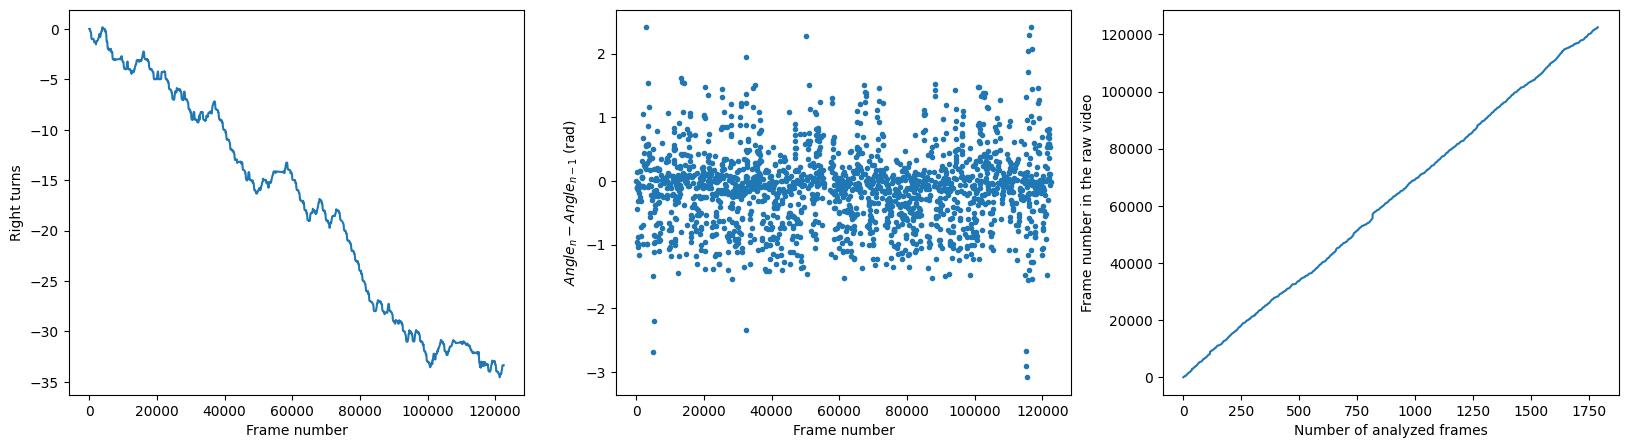

The animal made -33.35003130729399 right turns in segment 1
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240418_video\Temp\Image_Segment2
Starting to extract posture
Overall # of frames:  1038  found with (before cropping) frame dimensions:  880 704


 99%|█████████▉| 1030/1038 [00:34<00:00, 29.64it/s]


Saving results in F:\Ephys\Haitham\Videos\20240418_video\Temp\Image_Segment2...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240418_video\Temp\New1_Segment2/
Starting to extract posture
Overall # of frames:  425  found with (before cropping) frame dimensions:  880 704


 99%|█████████▉| 420/425 [00:14<00:00, 28.71it/s]


Saving results in F:\Ephys\Haitham\Videos\20240418_video\Temp\New1_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240418_video\Temp\New2_Segment2/
Starting to extract posture
Overall # of frames:  136  found with (before cropping) frame dimensions:  880 704


 96%|█████████▌| 130/136 [00:04<00:00, 26.64it/s]


Saving results in F:\Ephys\Haitham\Videos\20240418_video\Temp\New2_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240418_video\Temp\New3_Segment2/
Starting to extract posture
Overall # of frames:  99  found with (before cropping) frame dimensions:  880 704


 91%|█████████ | 90/99 [00:03<00:00, 24.07it/s]


Saving results in F:\Ephys\Haitham\Videos\20240418_video\Temp\New3_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240418_video\Temp\New4_Segment2/
Starting to extract posture
Overall # of frames:  91  found with (before cropping) frame dimensions:  880 704


 99%|█████████▉| 90/91 [00:03<00:00, 25.25it/s]


Saving results in F:\Ephys\Haitham\Videos\20240418_video\Temp\New4_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240418_video\Temp\New5_Segment2/
Starting to extract posture
Overall # of frames:  74  found with (before cropping) frame dimensions:  880 704


 95%|█████████▍| 70/74 [00:02<00:00, 23.97it/s]


Saving results in F:\Ephys\Haitham\Videos\20240418_video\Temp\New5_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240418_video\Temp\New6_Segment2/
Starting to extract posture
Overall # of frames:  46  found with (before cropping) frame dimensions:  880 704


 87%|████████▋ | 40/46 [00:02<00:00, 19.45it/s]


Saving results in F:\Ephys\Haitham\Videos\20240418_video\Temp\New6_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240418_video\Temp\New7_Segment2/
Starting to extract posture
Overall # of frames:  25  found with (before cropping) frame dimensions:  880 704


 80%|████████  | 20/25 [00:01<00:00, 14.03it/s]


Saving results in F:\Ephys\Haitham\Videos\20240418_video\Temp\New7_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240418_video\Temp\New8_Segment2/
Starting to extract posture
Overall # of frames:  12  found with (before cropping) frame dimensions:  880 704


 83%|████████▎ | 10/12 [00:00<00:00, 12.08it/s]


Saving results in F:\Ephys\Haitham\Videos\20240418_video\Temp\New8_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240418_video\Temp\New9_Segment2/
Starting to extract posture
Overall # of frames:  8  found with (before cropping) frame dimensions:  880 704


  0%|          | 0/8 [00:00<?, ?it/s]


Saving results in F:\Ephys\Haitham\Videos\20240418_video\Temp\New9_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240418_video\Temp\New10_Segment2/
Starting to extract posture
Overall # of frames:  6  found with (before cropping) frame dimensions:  880 704


  0%|          | 0/6 [00:00<?, ?it/s]


Saving results in F:\Ephys\Haitham\Videos\20240418_video\Temp\New10_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240418_video\Temp\New11_Segment2/
Starting to extract posture
Overall # of frames:  6  found with (before cropping) frame dimensions:  880 704


  0%|          | 0/6 [00:00<?, ?it/s]


Saving results in F:\Ephys\Haitham\Videos\20240418_video\Temp\New11_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
1371 out of 1966 frames are good.
1369 out of 1371 frames are good after filtering.


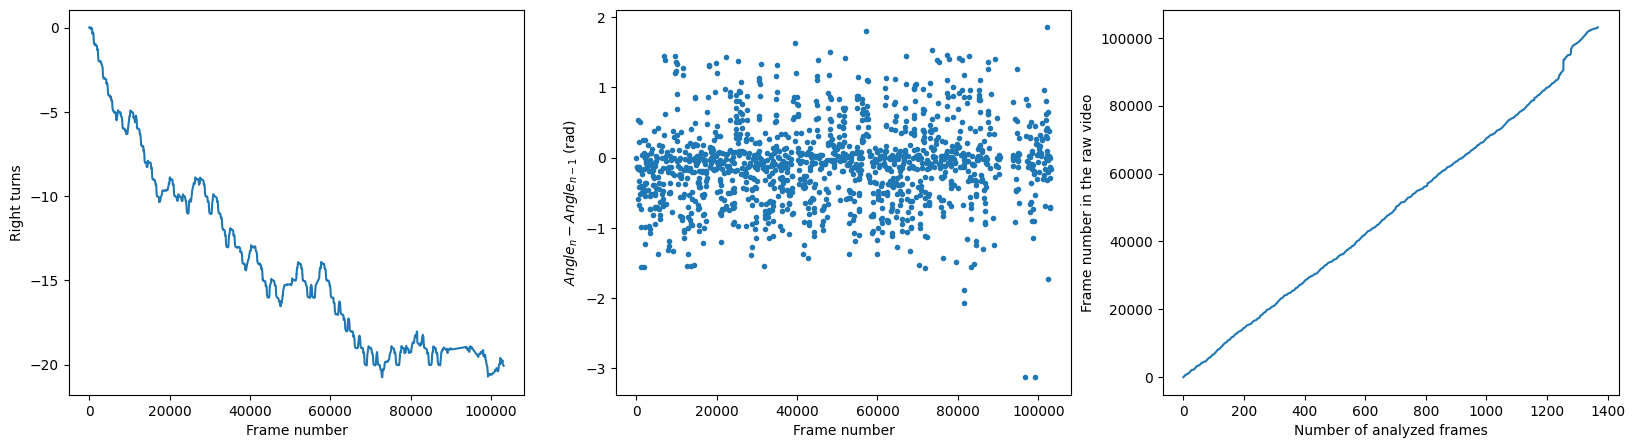

The animal made -20.062164021415082 right turns in segment 2
Analyzing F:\Ephys\Haitham\Videos\20240422_video ...
Temp folder: F:\Ephys\Haitham\Videos\20240422_video\Temp
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240422_video\Temp\Image_Segment1
Starting to extract posture
Overall # of frames:  1094  found with (before cropping) frame dimensions:  880 704


100%|█████████▉| 1090/1094 [00:35<00:00, 30.71it/s]


Saving results in F:\Ephys\Haitham\Videos\20240422_video\Temp\Image_Segment1...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240422_video\Temp\New1_Segment1/
Starting to extract posture
Overall # of frames:  528  found with (before cropping) frame dimensions:  880 704


 98%|█████████▊| 520/528 [00:17<00:00, 29.47it/s]


Saving results in F:\Ephys\Haitham\Videos\20240422_video\Temp\New1_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240422_video\Temp\New2_Segment1/
Starting to extract posture
Overall # of frames:  252  found with (before cropping) frame dimensions:  880 704


 99%|█████████▉| 250/252 [00:08<00:00, 28.60it/s]


Saving results in F:\Ephys\Haitham\Videos\20240422_video\Temp\New2_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240422_video\Temp\New3_Segment1/
Starting to extract posture
Overall # of frames:  217  found with (before cropping) frame dimensions:  880 704


 97%|█████████▋| 210/217 [00:07<00:00, 28.19it/s]


Saving results in F:\Ephys\Haitham\Videos\20240422_video\Temp\New3_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240422_video\Temp\New4_Segment1/
Starting to extract posture
Overall # of frames:  184  found with (before cropping) frame dimensions:  880 704


 98%|█████████▊| 180/184 [00:06<00:00, 29.05it/s]


Saving results in F:\Ephys\Haitham\Videos\20240422_video\Temp\New4_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240422_video\Temp\New5_Segment1/
Starting to extract posture
Overall # of frames:  132  found with (before cropping) frame dimensions:  880 704


 98%|█████████▊| 130/132 [00:04<00:00, 26.98it/s]


Saving results in F:\Ephys\Haitham\Videos\20240422_video\Temp\New5_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240422_video\Temp\New6_Segment1/
Starting to extract posture
Overall # of frames:  79  found with (before cropping) frame dimensions:  880 704


 89%|████████▊ | 70/79 [00:03<00:00, 22.67it/s]


Saving results in F:\Ephys\Haitham\Videos\20240422_video\Temp\New6_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240422_video\Temp\New7_Segment1/
Starting to extract posture
Overall # of frames:  43  found with (before cropping) frame dimensions:  880 704


 93%|█████████▎| 40/43 [00:01<00:00, 20.50it/s]


Saving results in F:\Ephys\Haitham\Videos\20240422_video\Temp\New7_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240422_video\Temp\New8_Segment1/
Starting to extract posture
Overall # of frames:  14  found with (before cropping) frame dimensions:  880 704


 71%|███████▏  | 10/14 [00:00<00:00, 11.27it/s]


Saving results in F:\Ephys\Haitham\Videos\20240422_video\Temp\New8_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240422_video\Temp\New9_Segment1/
Starting to extract posture
Overall # of frames:  14  found with (before cropping) frame dimensions:  880 704


 71%|███████▏  | 10/14 [00:00<00:00, 10.26it/s]


Saving results in F:\Ephys\Haitham\Videos\20240422_video\Temp\New9_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240422_video\Temp\New10_Segment1/
Starting to extract posture
Overall # of frames:  1  found with (before cropping) frame dimensions:  880 704


  0%|          | 0/1 [00:00<?, ?it/s]


Saving results in F:\Ephys\Haitham\Videos\20240422_video\Temp\New10_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
1489 out of 2558 frames are good.
1489 out of 1489 frames are good after filtering.


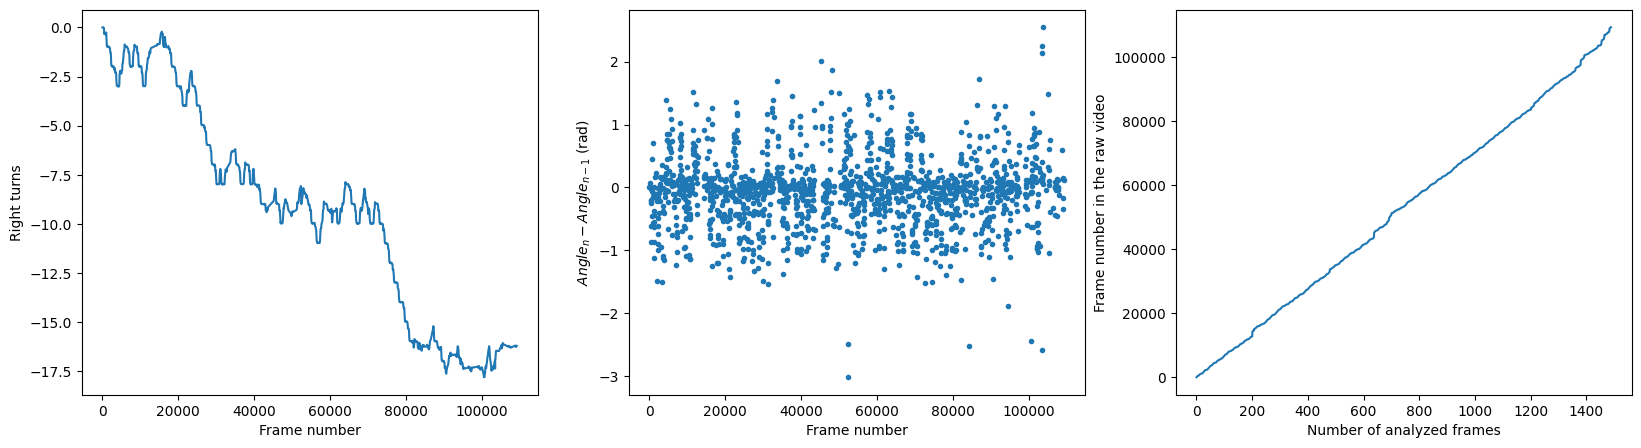

The animal made -16.2119751220313 right turns in segment 1
Analyzing F:\Ephys\Haitham\Videos\20240425_video ...
Temp folder: F:\Ephys\Haitham\Videos\20240425_video\Temp
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240425_video\Temp\Image_Segment1
Starting to extract posture
Overall # of frames:  1800  found with (before cropping) frame dimensions:  880 704


 99%|█████████▉| 1782/1800 [01:00<00:00, 29.46it/s]


Saving results in F:\Ephys\Haitham\Videos\20240425_video\Temp\Image_Segment1...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240425_video\Temp\New1_Segment1/
Starting to extract posture
Overall # of frames:  924  found with (before cropping) frame dimensions:  880 704


100%|█████████▉| 920/924 [00:30<00:00, 30.48it/s]


Saving results in F:\Ephys\Haitham\Videos\20240425_video\Temp\New1_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240425_video\Temp\New2_Segment1/
Starting to extract posture
Overall # of frames:  351  found with (before cropping) frame dimensions:  880 704


100%|█████████▉| 350/351 [00:11<00:00, 29.64it/s]


Saving results in F:\Ephys\Haitham\Videos\20240425_video\Temp\New2_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240425_video\Temp\New3_Segment1/
Starting to extract posture
Overall # of frames:  257  found with (before cropping) frame dimensions:  880 704


 97%|█████████▋| 250/257 [00:09<00:00, 26.47it/s]


Saving results in F:\Ephys\Haitham\Videos\20240425_video\Temp\New3_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240425_video\Temp\New4_Segment1/
Starting to extract posture
Overall # of frames:  243  found with (before cropping) frame dimensions:  880 704


 99%|█████████▉| 240/243 [00:08<00:00, 28.45it/s]


Saving results in F:\Ephys\Haitham\Videos\20240425_video\Temp\New4_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240425_video\Temp\New5_Segment1/
Starting to extract posture
Overall # of frames:  198  found with (before cropping) frame dimensions:  880 704


 96%|█████████▌| 190/198 [00:06<00:00, 27.23it/s]


Saving results in F:\Ephys\Haitham\Videos\20240425_video\Temp\New5_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240425_video\Temp\New6_Segment1/
Starting to extract posture
Overall # of frames:  115  found with (before cropping) frame dimensions:  880 704


 96%|█████████▌| 110/115 [00:04<00:00, 26.11it/s]


Saving results in F:\Ephys\Haitham\Videos\20240425_video\Temp\New6_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240425_video\Temp\New7_Segment1/
Starting to extract posture
Overall # of frames:  78  found with (before cropping) frame dimensions:  880 704


 90%|████████▉ | 70/78 [00:03<00:00, 23.15it/s]


Saving results in F:\Ephys\Haitham\Videos\20240425_video\Temp\New7_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240425_video\Temp\New8_Segment1/
Starting to extract posture
Overall # of frames:  39  found with (before cropping) frame dimensions:  880 704


 77%|███████▋  | 30/39 [00:01<00:00, 17.56it/s]


Saving results in F:\Ephys\Haitham\Videos\20240425_video\Temp\New8_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240425_video\Temp\New9_Segment1/
Starting to extract posture
Overall # of frames:  17  found with (before cropping) frame dimensions:  880 704


 59%|█████▉    | 10/17 [00:01<00:00,  8.56it/s]


Saving results in F:\Ephys\Haitham\Videos\20240425_video\Temp\New9_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240425_video\Temp\New10_Segment1/
Starting to extract posture
Overall # of frames:  8  found with (before cropping) frame dimensions:  880 704


  0%|          | 0/8 [00:00<?, ?it/s]


Saving results in F:\Ephys\Haitham\Videos\20240425_video\Temp\New10_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240425_video\Temp\New11_Segment1/
Starting to extract posture
Overall # of frames:  4  found with (before cropping) frame dimensions:  880 704


  0%|          | 0/4 [00:00<?, ?it/s]


Saving results in F:\Ephys\Haitham\Videos\20240425_video\Temp\New11_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240425_video\Temp\New12_Segment1/
Starting to extract posture
Overall # of frames:  4  found with (before cropping) frame dimensions:  880 704


  0%|          | 0/4 [00:00<?, ?it/s]


Saving results in F:\Ephys\Haitham\Videos\20240425_video\Temp\New12_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240425_video\Temp\New13_Segment1/
Starting to extract posture
Overall # of frames:  3  found with (before cropping) frame dimensions:  880 704


  0%|          | 0/3 [00:00<?, ?it/s]


Saving results in F:\Ephys\Haitham\Videos\20240425_video\Temp\New13_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240425_video\Temp\New14_Segment1/
Starting to extract posture
Overall # of frames:  4  found with (before cropping) frame dimensions:  880 704


  0%|          | 0/4 [00:00<?, ?it/s]


Saving results in F:\Ephys\Haitham\Videos\20240425_video\Temp\New14_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
2738 out of 4045 frames are good.
2737 out of 2738 frames are good after filtering.


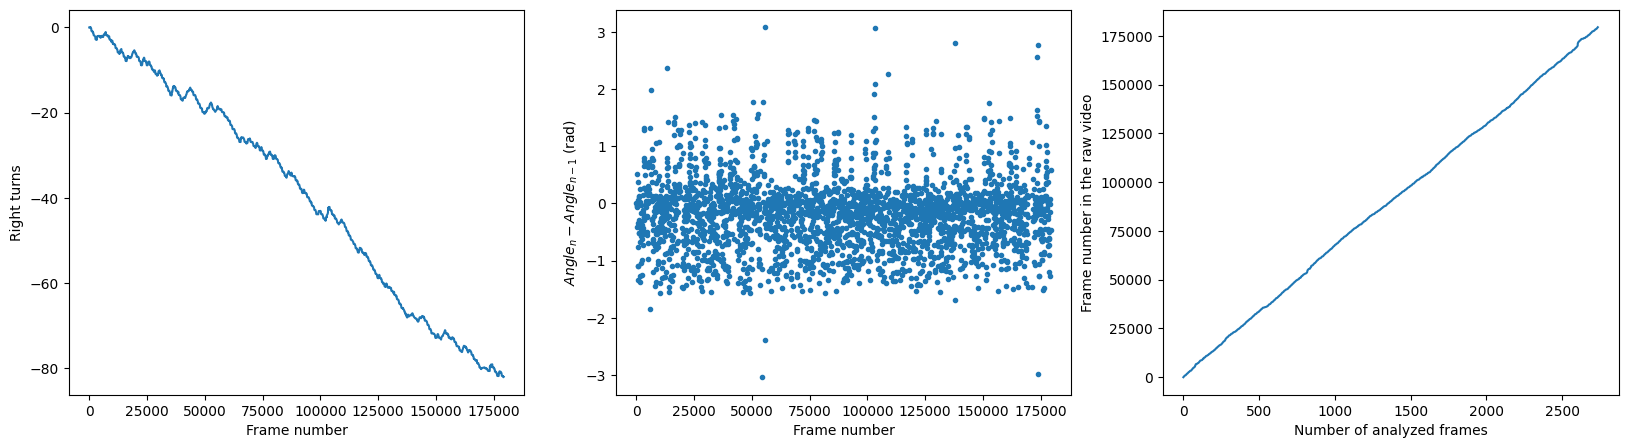

The animal made -82.02521821458537 right turns in segment 1
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240425_video\Temp\Image_Segment2
Starting to extract posture
Overall # of frames:  1263  found with (before cropping) frame dimensions:  880 704


100%|█████████▉| 1260/1263 [00:40<00:00, 30.90it/s]


Saving results in F:\Ephys\Haitham\Videos\20240425_video\Temp\Image_Segment2...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240425_video\Temp\New1_Segment2/
Starting to extract posture
Overall # of frames:  544  found with (before cropping) frame dimensions:  880 704


 99%|█████████▉| 540/544 [00:17<00:00, 30.23it/s]


Saving results in F:\Ephys\Haitham\Videos\20240425_video\Temp\New1_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240425_video\Temp\New2_Segment2/
Starting to extract posture
Overall # of frames:  335  found with (before cropping) frame dimensions:  880 704


 99%|█████████▊| 330/335 [00:11<00:00, 29.52it/s]


Saving results in F:\Ephys\Haitham\Videos\20240425_video\Temp\New2_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240425_video\Temp\New3_Segment2/
Starting to extract posture
Overall # of frames:  283  found with (before cropping) frame dimensions:  880 704


 99%|█████████▉| 280/283 [00:09<00:00, 28.93it/s]


Saving results in F:\Ephys\Haitham\Videos\20240425_video\Temp\New3_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240425_video\Temp\New4_Segment2/
Starting to extract posture
Overall # of frames:  234  found with (before cropping) frame dimensions:  880 704


 98%|█████████▊| 230/234 [00:08<00:00, 28.35it/s]


Saving results in F:\Ephys\Haitham\Videos\20240425_video\Temp\New4_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240425_video\Temp\New5_Segment2/
Starting to extract posture
Overall # of frames:  177  found with (before cropping) frame dimensions:  880 704


 96%|█████████▌| 170/177 [00:06<00:00, 27.70it/s]


Saving results in F:\Ephys\Haitham\Videos\20240425_video\Temp\New5_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240425_video\Temp\New6_Segment2/
Starting to extract posture
Overall # of frames:  127  found with (before cropping) frame dimensions:  880 704


 94%|█████████▍| 120/127 [00:04<00:00, 26.58it/s]


Saving results in F:\Ephys\Haitham\Videos\20240425_video\Temp\New6_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240425_video\Temp\New7_Segment2/
Starting to extract posture
Overall # of frames:  98  found with (before cropping) frame dimensions:  880 704


 92%|█████████▏| 90/98 [00:03<00:00, 24.06it/s]


Saving results in F:\Ephys\Haitham\Videos\20240425_video\Temp\New7_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240425_video\Temp\New8_Segment2/
Starting to extract posture
Overall # of frames:  49  found with (before cropping) frame dimensions:  880 704


 82%|████████▏ | 40/49 [00:02<00:00, 19.21it/s]


Saving results in F:\Ephys\Haitham\Videos\20240425_video\Temp\New8_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240425_video\Temp\New9_Segment2/
Starting to extract posture
Overall # of frames:  46  found with (before cropping) frame dimensions:  880 704


 87%|████████▋ | 40/46 [00:01<00:00, 20.06it/s]


Saving results in F:\Ephys\Haitham\Videos\20240425_video\Temp\New9_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240425_video\Temp\New10_Segment2/
Starting to extract posture
Overall # of frames:  35  found with (before cropping) frame dimensions:  880 704


 86%|████████▌ | 30/35 [00:01<00:00, 18.57it/s]


Saving results in F:\Ephys\Haitham\Videos\20240425_video\Temp\New10_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240425_video\Temp\New11_Segment2/
Starting to extract posture
Overall # of frames:  17  found with (before cropping) frame dimensions:  880 704


 59%|█████▉    | 10/17 [00:01<00:00,  8.58it/s]


Saving results in F:\Ephys\Haitham\Videos\20240425_video\Temp\New11_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240425_video\Temp\New12_Segment2/
Starting to extract posture
Overall # of frames:  15  found with (before cropping) frame dimensions:  880 704


 67%|██████▋   | 10/15 [00:00<00:00, 10.69it/s]


Saving results in F:\Ephys\Haitham\Videos\20240425_video\Temp\New12_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240425_video\Temp\New13_Segment2/
Starting to extract posture
Overall # of frames:  2  found with (before cropping) frame dimensions:  880 704


  0%|          | 0/2 [00:00<?, ?it/s]


Saving results in F:\Ephys\Haitham\Videos\20240425_video\Temp\New13_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
1506 out of 3225 frames are good.
1505 out of 1506 frames are good after filtering.


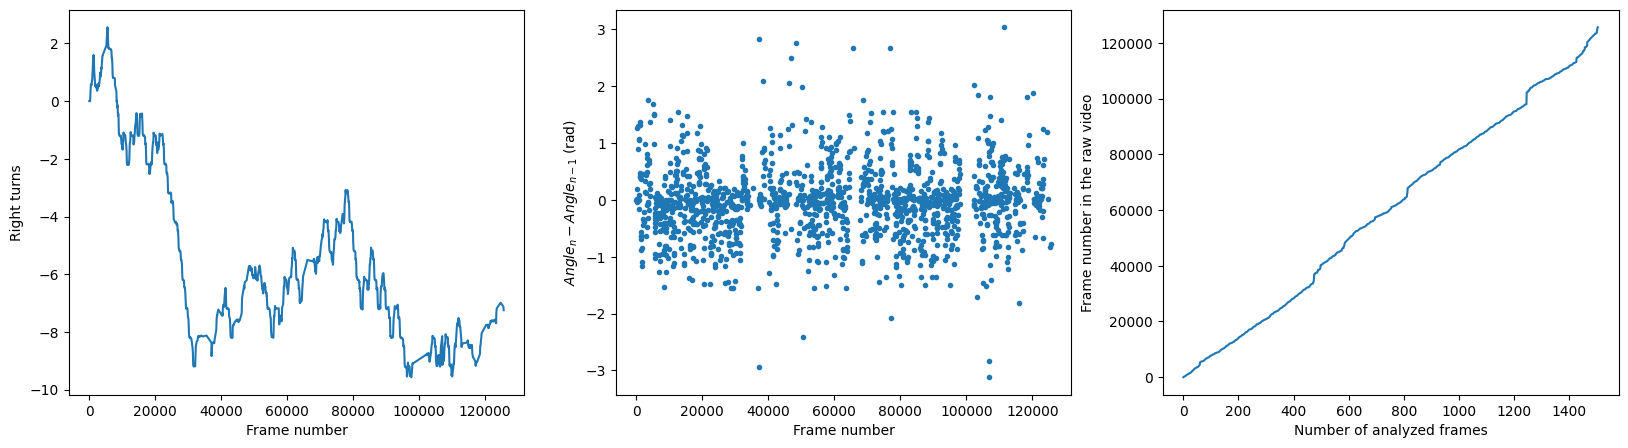

The animal made -7.24662268760544 right turns in segment 2
Analyzing F:\Ephys\Haitham\Videos\20240427_video ...
Temp folder: F:\Ephys\Haitham\Videos\20240427_video\Temp
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240427_video\Temp\Image_Segment1
Starting to extract posture
Overall # of frames:  1800  found with (before cropping) frame dimensions:  880 704


 99%|█████████▉| 1782/1800 [00:56<00:00, 31.79it/s]


Saving results in F:\Ephys\Haitham\Videos\20240427_video\Temp\Image_Segment1...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240427_video\Temp\New1_Segment1/
Starting to extract posture
Overall # of frames:  806  found with (before cropping) frame dimensions:  880 704


 99%|█████████▉| 800/806 [00:26<00:00, 30.34it/s]


Saving results in F:\Ephys\Haitham\Videos\20240427_video\Temp\New1_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240427_video\Temp\New2_Segment1/
Starting to extract posture
Overall # of frames:  303  found with (before cropping) frame dimensions:  880 704


 99%|█████████▉| 300/303 [00:10<00:00, 29.42it/s]


Saving results in F:\Ephys\Haitham\Videos\20240427_video\Temp\New2_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240427_video\Temp\New3_Segment1/
Starting to extract posture
Overall # of frames:  216  found with (before cropping) frame dimensions:  880 704


 97%|█████████▋| 210/216 [00:07<00:00, 28.51it/s]


Saving results in F:\Ephys\Haitham\Videos\20240427_video\Temp\New3_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240427_video\Temp\New4_Segment1/
Starting to extract posture
Overall # of frames:  162  found with (before cropping) frame dimensions:  880 704


 99%|█████████▉| 160/162 [00:05<00:00, 27.88it/s]


Saving results in F:\Ephys\Haitham\Videos\20240427_video\Temp\New4_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240427_video\Temp\New5_Segment1/
Starting to extract posture
Overall # of frames:  123  found with (before cropping) frame dimensions:  880 704


 98%|█████████▊| 120/123 [00:04<00:00, 26.38it/s]


Saving results in F:\Ephys\Haitham\Videos\20240427_video\Temp\New5_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240427_video\Temp\New6_Segment1/
Starting to extract posture
Overall # of frames:  54  found with (before cropping) frame dimensions:  880 704


 93%|█████████▎| 50/54 [00:02<00:00, 22.65it/s]


Saving results in F:\Ephys\Haitham\Videos\20240427_video\Temp\New6_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240427_video\Temp\New7_Segment1/
Starting to extract posture
Overall # of frames:  29  found with (before cropping) frame dimensions:  880 704


 69%|██████▉   | 20/29 [00:01<00:00, 13.91it/s]


Saving results in F:\Ephys\Haitham\Videos\20240427_video\Temp\New7_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240427_video\Temp\New8_Segment1/
Starting to extract posture
Overall # of frames:  18  found with (before cropping) frame dimensions:  880 704


 56%|█████▌    | 10/18 [00:01<00:00,  9.50it/s]


Saving results in F:\Ephys\Haitham\Videos\20240427_video\Temp\New8_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240427_video\Temp\New9_Segment1/
Starting to extract posture
Overall # of frames:  7  found with (before cropping) frame dimensions:  880 704


  0%|          | 0/7 [00:00<?, ?it/s]


Saving results in F:\Ephys\Haitham\Videos\20240427_video\Temp\New9_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240427_video\Temp\New10_Segment1/
Starting to extract posture
Overall # of frames:  3  found with (before cropping) frame dimensions:  880 704


  0%|          | 0/3 [00:00<?, ?it/s]


Saving results in F:\Ephys\Haitham\Videos\20240427_video\Temp\New10_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240427_video\Temp\New11_Segment1/
Starting to extract posture
Overall # of frames:  3  found with (before cropping) frame dimensions:  880 704


  0%|          | 0/3 [00:00<?, ?it/s]


Saving results in F:\Ephys\Haitham\Videos\20240427_video\Temp\New11_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
2558 out of 3524 frames are good.
2554 out of 2558 frames are good after filtering.


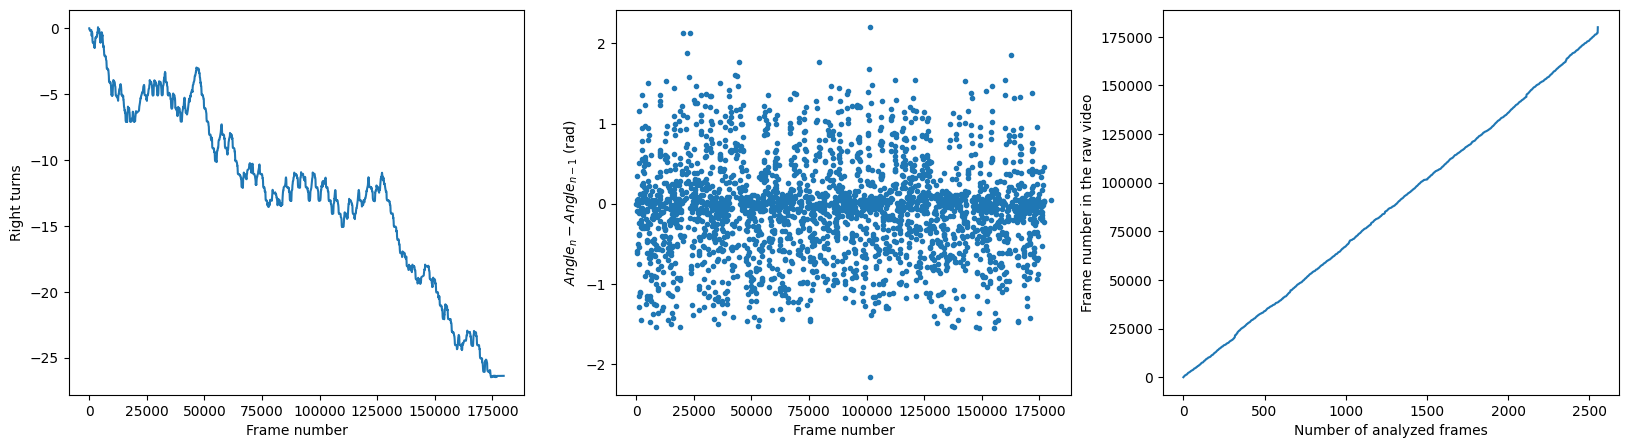

The animal made -26.38285101998502 right turns in segment 1
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240427_video\Temp\Image_Segment2
Starting to extract posture
Overall # of frames:  1800  found with (before cropping) frame dimensions:  880 704


 99%|█████████▉| 1782/1800 [00:57<00:00, 30.80it/s]


Saving results in F:\Ephys\Haitham\Videos\20240427_video\Temp\Image_Segment2...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240427_video\Temp\New1_Segment2/
Starting to extract posture
Overall # of frames:  684  found with (before cropping) frame dimensions:  880 704


 99%|█████████▉| 680/684 [00:22<00:00, 30.49it/s]


Saving results in F:\Ephys\Haitham\Videos\20240427_video\Temp\New1_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240427_video\Temp\New2_Segment2/
Starting to extract posture
Overall # of frames:  346  found with (before cropping) frame dimensions:  880 704


 98%|█████████▊| 340/346 [00:11<00:00, 29.08it/s]


Saving results in F:\Ephys\Haitham\Videos\20240427_video\Temp\New2_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240427_video\Temp\New3_Segment2/
Starting to extract posture
Overall # of frames:  292  found with (before cropping) frame dimensions:  880 704


 99%|█████████▉| 290/292 [00:09<00:00, 29.22it/s]


Saving results in F:\Ephys\Haitham\Videos\20240427_video\Temp\New3_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240427_video\Temp\New4_Segment2/
Starting to extract posture
Overall # of frames:  264  found with (before cropping) frame dimensions:  880 704


 98%|█████████▊| 260/264 [00:08<00:00, 29.70it/s]


Saving results in F:\Ephys\Haitham\Videos\20240427_video\Temp\New4_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240427_video\Temp\New5_Segment2/
Starting to extract posture
Overall # of frames:  207  found with (before cropping) frame dimensions:  880 704


 97%|█████████▋| 200/207 [00:07<00:00, 28.03it/s]


Saving results in F:\Ephys\Haitham\Videos\20240427_video\Temp\New5_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240427_video\Temp\New6_Segment2/
Starting to extract posture
Overall # of frames:  130  found with (before cropping) frame dimensions:  880 704


 92%|█████████▏| 120/130 [00:04<00:00, 25.63it/s]


Saving results in F:\Ephys\Haitham\Videos\20240427_video\Temp\New6_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240427_video\Temp\New7_Segment2/
Starting to extract posture
Overall # of frames:  86  found with (before cropping) frame dimensions:  880 704


 93%|█████████▎| 80/86 [00:03<00:00, 24.41it/s]


Saving results in F:\Ephys\Haitham\Videos\20240427_video\Temp\New7_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240427_video\Temp\New8_Segment2/
Starting to extract posture
Overall # of frames:  39  found with (before cropping) frame dimensions:  880 704


 77%|███████▋  | 30/39 [00:01<00:00, 17.43it/s]


Saving results in F:\Ephys\Haitham\Videos\20240427_video\Temp\New8_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240427_video\Temp\New9_Segment2/
Starting to extract posture
Overall # of frames:  18  found with (before cropping) frame dimensions:  880 704


 56%|█████▌    | 10/18 [00:01<00:00,  9.29it/s]


Saving results in F:\Ephys\Haitham\Videos\20240427_video\Temp\New9_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240427_video\Temp\New10_Segment2/
Starting to extract posture
Overall # of frames:  4  found with (before cropping) frame dimensions:  880 704


  0%|          | 0/4 [00:00<?, ?it/s]


Saving results in F:\Ephys\Haitham\Videos\20240427_video\Temp\New10_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240427_video\Temp\New11_Segment2/
Starting to extract posture
Overall # of frames:  2  found with (before cropping) frame dimensions:  880 704


  0%|          | 0/2 [00:00<?, ?it/s]


Saving results in F:\Ephys\Haitham\Videos\20240427_video\Temp\New11_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240427_video\Temp\New12_Segment2/
Starting to extract posture
Overall # of frames:  4  found with (before cropping) frame dimensions:  880 704


  0%|          | 0/4 [00:00<?, ?it/s]


Saving results in F:\Ephys\Haitham\Videos\20240427_video\Temp\New12_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
2284 out of 3876 frames are good.
2280 out of 2284 frames are good after filtering.


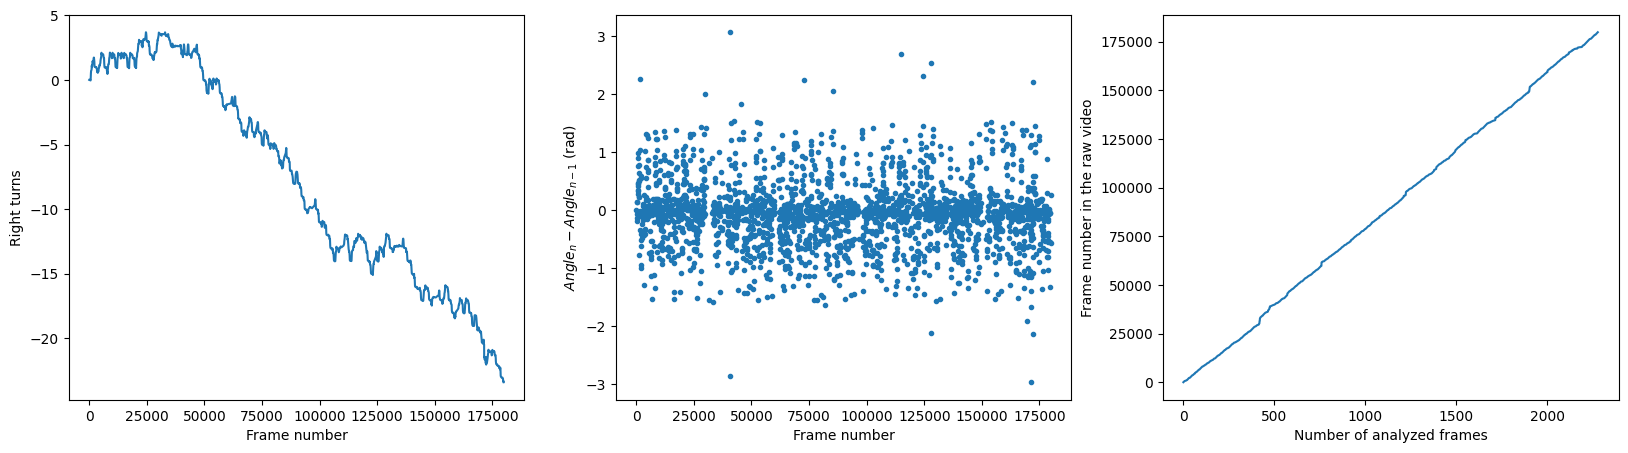

The animal made -23.402369739888805 right turns in segment 2
Analyzing F:\Ephys\Haitham\Videos\20240506_video ...
Temp folder: F:\Ephys\Haitham\Videos\20240506_video\Temp
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240506_video\Temp\Image_Segment1
Starting to extract posture
Overall # of frames:  1800  found with (before cropping) frame dimensions:  880 704


 99%|█████████▉| 1782/1800 [00:58<00:00, 30.69it/s]


Saving results in F:\Ephys\Haitham\Videos\20240506_video\Temp\Image_Segment1...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240506_video\Temp\New1_Segment1/
Starting to extract posture
Overall # of frames:  744  found with (before cropping) frame dimensions:  880 704


 99%|█████████▉| 740/744 [00:24<00:00, 30.35it/s]


Saving results in F:\Ephys\Haitham\Videos\20240506_video\Temp\New1_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240506_video\Temp\New2_Segment1/
Starting to extract posture
Overall # of frames:  458  found with (before cropping) frame dimensions:  880 704


 98%|█████████▊| 450/458 [00:15<00:00, 29.67it/s]


Saving results in F:\Ephys\Haitham\Videos\20240506_video\Temp\New2_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240506_video\Temp\New3_Segment1/
Starting to extract posture
Overall # of frames:  318  found with (before cropping) frame dimensions:  880 704


 97%|█████████▋| 310/318 [00:10<00:00, 28.68it/s]


Saving results in F:\Ephys\Haitham\Videos\20240506_video\Temp\New3_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240506_video\Temp\New4_Segment1/
Starting to extract posture
Overall # of frames:  301  found with (before cropping) frame dimensions:  880 704


100%|█████████▉| 300/301 [00:10<00:00, 29.78it/s]


Saving results in F:\Ephys\Haitham\Videos\20240506_video\Temp\New4_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240506_video\Temp\New5_Segment1/
Starting to extract posture
Overall # of frames:  204  found with (before cropping) frame dimensions:  880 704


 98%|█████████▊| 200/204 [00:07<00:00, 28.21it/s]


Saving results in F:\Ephys\Haitham\Videos\20240506_video\Temp\New5_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240506_video\Temp\New6_Segment1/
Starting to extract posture
Overall # of frames:  130  found with (before cropping) frame dimensions:  880 704


 92%|█████████▏| 120/130 [00:04<00:00, 24.82it/s]


Saving results in F:\Ephys\Haitham\Videos\20240506_video\Temp\New6_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240506_video\Temp\New7_Segment1/
Starting to extract posture
Overall # of frames:  63  found with (before cropping) frame dimensions:  880 704


 95%|█████████▌| 60/63 [00:02<00:00, 24.25it/s]


Saving results in F:\Ephys\Haitham\Videos\20240506_video\Temp\New7_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240506_video\Temp\New8_Segment1/
Starting to extract posture
Overall # of frames:  31  found with (before cropping) frame dimensions:  880 704


 97%|█████████▋| 30/31 [00:01<00:00, 20.60it/s]


Saving results in F:\Ephys\Haitham\Videos\20240506_video\Temp\New8_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240506_video\Temp\New9_Segment1/
Starting to extract posture
Overall # of frames:  21  found with (before cropping) frame dimensions:  880 704


 95%|█████████▌| 20/21 [00:01<00:00, 16.22it/s]


Saving results in F:\Ephys\Haitham\Videos\20240506_video\Temp\New9_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240506_video\Temp\New10_Segment1/
Starting to extract posture
Overall # of frames:  9  found with (before cropping) frame dimensions:  880 704


  0%|          | 0/9 [00:00<?, ?it/s]


Saving results in F:\Ephys\Haitham\Videos\20240506_video\Temp\New10_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240506_video\Temp\New11_Segment1/
Starting to extract posture
Overall # of frames:  10  found with (before cropping) frame dimensions:  880 704


  0%|          | 0/10 [00:00<?, ?it/s]


Saving results in F:\Ephys\Haitham\Videos\20240506_video\Temp\New11_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240506_video\Temp\New12_Segment1/
Starting to extract posture
Overall # of frames:  2  found with (before cropping) frame dimensions:  880 704


  0%|          | 0/2 [00:00<?, ?it/s]


Saving results in F:\Ephys\Haitham\Videos\20240506_video\Temp\New12_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240506_video\Temp\New13_Segment1/
Starting to extract posture
Overall # of frames:  3  found with (before cropping) frame dimensions:  880 704


  0%|          | 0/3 [00:00<?, ?it/s]


Saving results in F:\Ephys\Haitham\Videos\20240506_video\Temp\New13_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240506_video\Temp\New14_Segment1/
Starting to extract posture
Overall # of frames:  2  found with (before cropping) frame dimensions:  880 704


  0%|          | 0/2 [00:00<?, ?it/s]


Saving results in F:\Ephys\Haitham\Videos\20240506_video\Temp\New14_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240506_video\Temp\New15_Segment1/
Starting to extract posture
Overall # of frames:  4  found with (before cropping) frame dimensions:  880 704


  0%|          | 0/4 [00:00<?, ?it/s]


Saving results in F:\Ephys\Haitham\Videos\20240506_video\Temp\New15_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
2582 out of 4100 frames are good.
2582 out of 2582 frames are good after filtering.


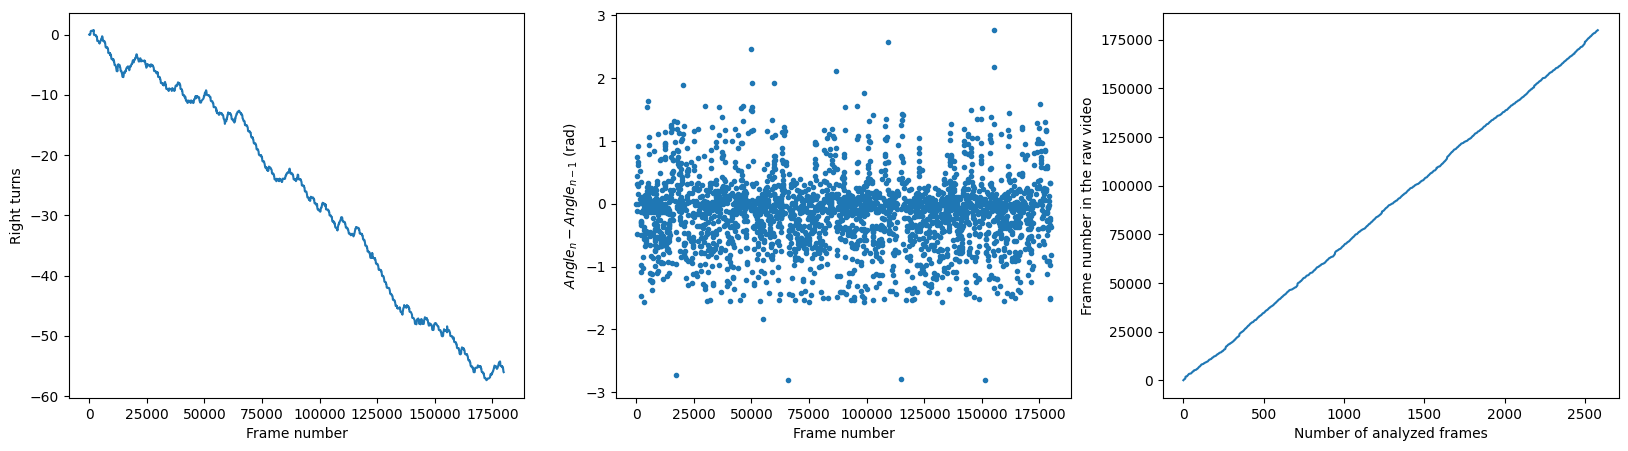

The animal made -56.02964421017348 right turns in segment 1
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240506_video\Temp\Image_Segment2
Starting to extract posture
Overall # of frames:  1000  found with (before cropping) frame dimensions:  880 704


 99%|█████████▉| 990/1000 [00:32<00:00, 30.42it/s]


Saving results in F:\Ephys\Haitham\Videos\20240506_video\Temp\Image_Segment2...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240506_video\Temp\New1_Segment2/
Starting to extract posture
Overall # of frames:  405  found with (before cropping) frame dimensions:  880 704


 99%|█████████▉| 400/405 [00:13<00:00, 29.05it/s]


Saving results in F:\Ephys\Haitham\Videos\20240506_video\Temp\New1_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240506_video\Temp\New2_Segment2/
Starting to extract posture
Overall # of frames:  346  found with (before cropping) frame dimensions:  880 704


 98%|█████████▊| 340/346 [00:11<00:00, 28.70it/s]


Saving results in F:\Ephys\Haitham\Videos\20240506_video\Temp\New2_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240506_video\Temp\New3_Segment2/
Starting to extract posture
Overall # of frames:  252  found with (before cropping) frame dimensions:  880 704


 99%|█████████▉| 250/252 [00:08<00:00, 28.65it/s]


Saving results in F:\Ephys\Haitham\Videos\20240506_video\Temp\New3_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240506_video\Temp\New4_Segment2/
Starting to extract posture
Overall # of frames:  246  found with (before cropping) frame dimensions:  880 704


 98%|█████████▊| 240/246 [00:08<00:00, 27.85it/s]


Saving results in F:\Ephys\Haitham\Videos\20240506_video\Temp\New4_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240506_video\Temp\New5_Segment2/
Starting to extract posture
Overall # of frames:  176  found with (before cropping) frame dimensions:  880 704


 97%|█████████▋| 170/176 [00:06<00:00, 27.28it/s]


Saving results in F:\Ephys\Haitham\Videos\20240506_video\Temp\New5_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240506_video\Temp\New6_Segment2/
Starting to extract posture
Overall # of frames:  134  found with (before cropping) frame dimensions:  880 704


 97%|█████████▋| 130/134 [00:05<00:00, 25.46it/s]


Saving results in F:\Ephys\Haitham\Videos\20240506_video\Temp\New6_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240506_video\Temp\New7_Segment2/
Starting to extract posture
Overall # of frames:  99  found with (before cropping) frame dimensions:  880 704


 91%|█████████ | 90/99 [00:04<00:00, 22.43it/s]


Saving results in F:\Ephys\Haitham\Videos\20240506_video\Temp\New7_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240506_video\Temp\New8_Segment2/
Starting to extract posture
Overall # of frames:  73  found with (before cropping) frame dimensions:  880 704


 96%|█████████▌| 70/73 [00:03<00:00, 22.52it/s]


Saving results in F:\Ephys\Haitham\Videos\20240506_video\Temp\New8_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240506_video\Temp\New9_Segment2/
Starting to extract posture
Overall # of frames:  51  found with (before cropping) frame dimensions:  880 704


 98%|█████████▊| 50/51 [00:02<00:00, 21.97it/s]


Saving results in F:\Ephys\Haitham\Videos\20240506_video\Temp\New9_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240506_video\Temp\New10_Segment2/
Starting to extract posture
Overall # of frames:  38  found with (before cropping) frame dimensions:  880 704


 79%|███████▉  | 30/38 [00:01<00:00, 17.36it/s]


Saving results in F:\Ephys\Haitham\Videos\20240506_video\Temp\New10_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240506_video\Temp\New11_Segment2/
Starting to extract posture
Overall # of frames:  14  found with (before cropping) frame dimensions:  880 704


 71%|███████▏  | 10/14 [00:00<00:00, 11.30it/s]


Saving results in F:\Ephys\Haitham\Videos\20240506_video\Temp\New11_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240506_video\Temp\New12_Segment2/
Starting to extract posture
Overall # of frames:  18  found with (before cropping) frame dimensions:  880 704


 56%|█████▌    | 10/18 [00:01<00:01,  7.88it/s]


Saving results in F:\Ephys\Haitham\Videos\20240506_video\Temp\New12_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240506_video\Temp\New13_Segment2/
Starting to extract posture
Overall # of frames:  4  found with (before cropping) frame dimensions:  880 704


  0%|          | 0/4 [00:00<?, ?it/s]


Saving results in F:\Ephys\Haitham\Videos\20240506_video\Temp\New13_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240506_video\Temp\New14_Segment2/
Starting to extract posture
Overall # of frames:  2  found with (before cropping) frame dimensions:  880 704


  0%|          | 0/2 [00:00<?, ?it/s]


Saving results in F:\Ephys\Haitham\Videos\20240506_video\Temp\New14_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
1306 out of 2858 frames are good.
1304 out of 1306 frames are good after filtering.


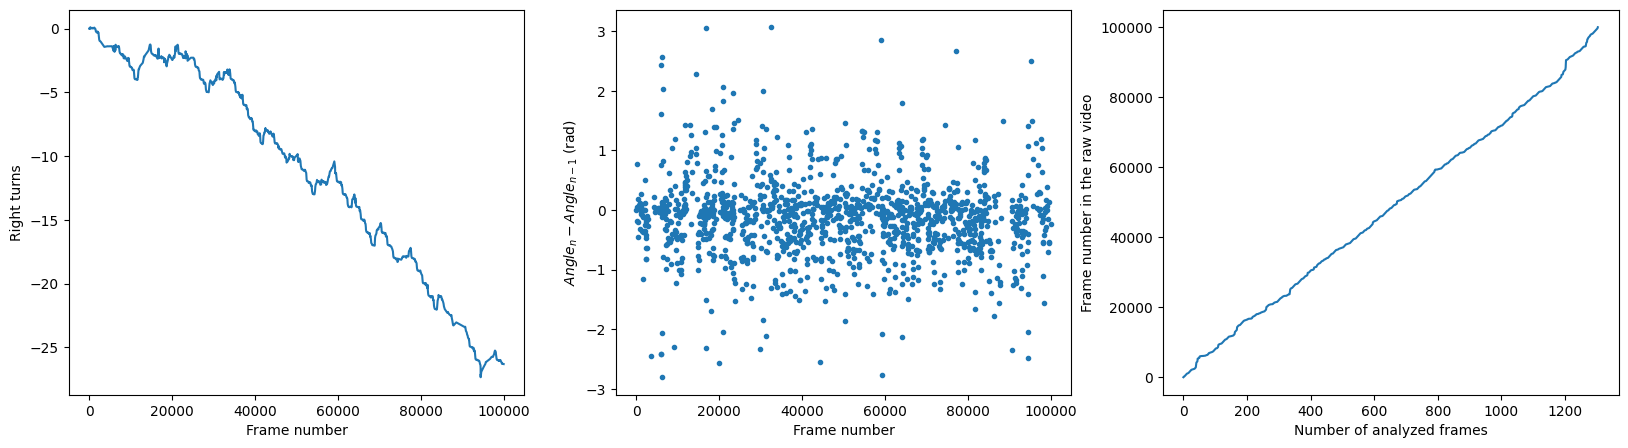

The animal made -26.31264530152466 right turns in segment 2
Analyzing F:\Ephys\Haitham\Videos\20240511_video ...
Temp folder: F:\Ephys\Haitham\Videos\20240511_video\Temp
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240511_video\Temp\Image_Segment1
Starting to extract posture
Overall # of frames:  1800  found with (before cropping) frame dimensions:  880 704


 99%|█████████▉| 1782/1800 [01:00<00:00, 29.32it/s]


Saving results in F:\Ephys\Haitham\Videos\20240511_video\Temp\Image_Segment1...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240511_video\Temp\New1_Segment1/
Starting to extract posture
Overall # of frames:  877  found with (before cropping) frame dimensions:  880 704


 99%|█████████▉| 870/877 [00:30<00:00, 28.70it/s]


Saving results in F:\Ephys\Haitham\Videos\20240511_video\Temp\New1_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240511_video\Temp\New2_Segment1/
Starting to extract posture
Overall # of frames:  496  found with (before cropping) frame dimensions:  880 704


 99%|█████████▉| 490/496 [00:16<00:00, 29.26it/s]


Saving results in F:\Ephys\Haitham\Videos\20240511_video\Temp\New2_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240511_video\Temp\New3_Segment1/
Starting to extract posture
Overall # of frames:  364  found with (before cropping) frame dimensions:  880 704


 99%|█████████▉| 360/364 [00:12<00:00, 28.04it/s]


Saving results in F:\Ephys\Haitham\Videos\20240511_video\Temp\New3_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240511_video\Temp\New4_Segment1/
Starting to extract posture
Overall # of frames:  269  found with (before cropping) frame dimensions:  880 704


 97%|█████████▋| 260/269 [00:09<00:00, 28.00it/s]


Saving results in F:\Ephys\Haitham\Videos\20240511_video\Temp\New4_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240511_video\Temp\New5_Segment1/
Starting to extract posture
Overall # of frames:  193  found with (before cropping) frame dimensions:  880 704


 98%|█████████▊| 190/193 [00:07<00:00, 26.39it/s]


Saving results in F:\Ephys\Haitham\Videos\20240511_video\Temp\New5_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240511_video\Temp\New6_Segment1/
Starting to extract posture
Overall # of frames:  99  found with (before cropping) frame dimensions:  880 704


 91%|█████████ | 90/99 [00:03<00:00, 23.38it/s]


Saving results in F:\Ephys\Haitham\Videos\20240511_video\Temp\New6_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240511_video\Temp\New7_Segment1/
Starting to extract posture
Overall # of frames:  64  found with (before cropping) frame dimensions:  880 704


 94%|█████████▍| 60/64 [00:02<00:00, 23.84it/s]


Saving results in F:\Ephys\Haitham\Videos\20240511_video\Temp\New7_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240511_video\Temp\New8_Segment1/
Starting to extract posture
Overall # of frames:  39  found with (before cropping) frame dimensions:  880 704


 77%|███████▋  | 30/39 [00:01<00:00, 17.12it/s]


Saving results in F:\Ephys\Haitham\Videos\20240511_video\Temp\New8_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240511_video\Temp\New9_Segment1/
Starting to extract posture
Overall # of frames:  21  found with (before cropping) frame dimensions:  880 704


 95%|█████████▌| 20/21 [00:01<00:00, 16.77it/s]


Saving results in F:\Ephys\Haitham\Videos\20240511_video\Temp\New9_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240511_video\Temp\New10_Segment1/
Starting to extract posture
Overall # of frames:  10  found with (before cropping) frame dimensions:  880 704


  0%|          | 0/10 [00:00<?, ?it/s]


Saving results in F:\Ephys\Haitham\Videos\20240511_video\Temp\New10_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240511_video\Temp\New11_Segment1/
Starting to extract posture
Overall # of frames:  1  found with (before cropping) frame dimensions:  880 704


  0%|          | 0/1 [00:00<?, ?it/s]


Saving results in F:\Ephys\Haitham\Videos\20240511_video\Temp\New11_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240511_video\Temp\New12_Segment1/
Starting to extract posture
Overall # of frames:  1  found with (before cropping) frame dimensions:  880 704


  0%|          | 0/1 [00:00<?, ?it/s]


Saving results in F:\Ephys\Haitham\Videos\20240511_video\Temp\New12_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
2765 out of 4234 frames are good.
2761 out of 2765 frames are good after filtering.


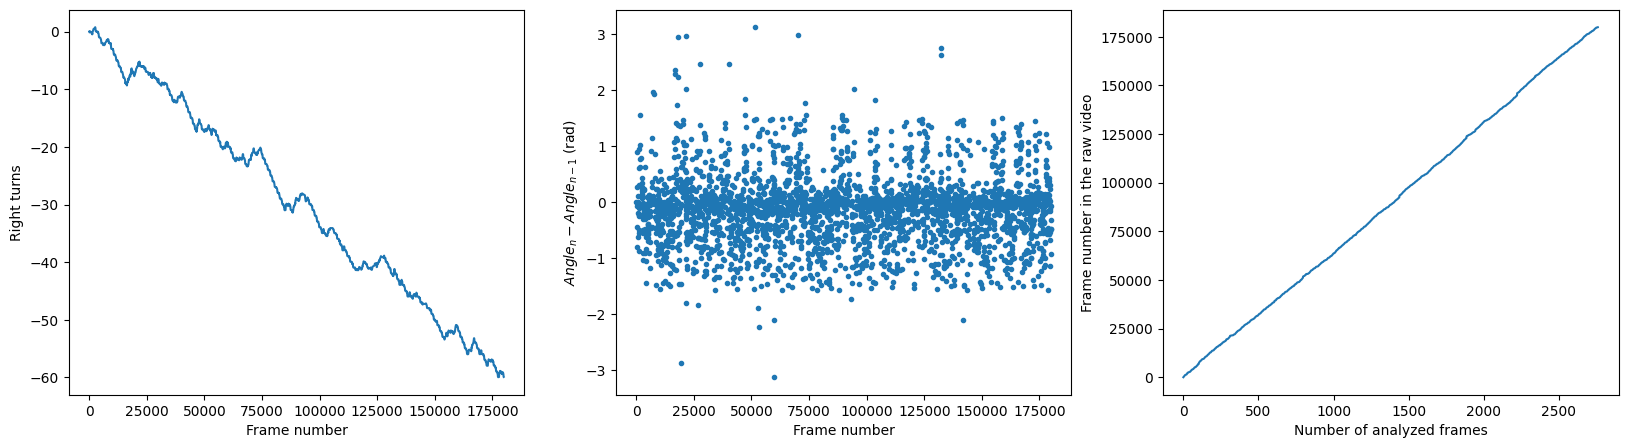

The animal made -59.91353219835701 right turns in segment 1
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240511_video\Temp\Image_Segment2
Starting to extract posture
Overall # of frames:  1253  found with (before cropping) frame dimensions:  880 704


100%|█████████▉| 1248/1253 [00:42<00:00, 29.47it/s]


Saving results in F:\Ephys\Haitham\Videos\20240511_video\Temp\Image_Segment2...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240511_video\Temp\New1_Segment2/
Starting to extract posture
Overall # of frames:  610  found with (before cropping) frame dimensions:  880 704


 98%|█████████▊| 600/610 [00:21<00:00, 28.49it/s]


Saving results in F:\Ephys\Haitham\Videos\20240511_video\Temp\New1_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240511_video\Temp\New2_Segment2/
Starting to extract posture
Overall # of frames:  334  found with (before cropping) frame dimensions:  880 704


 99%|█████████▉| 330/334 [00:11<00:00, 27.84it/s]


Saving results in F:\Ephys\Haitham\Videos\20240511_video\Temp\New2_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240511_video\Temp\New3_Segment2/
Starting to extract posture
Overall # of frames:  256  found with (before cropping) frame dimensions:  880 704


 98%|█████████▊| 250/256 [00:09<00:00, 27.26it/s]


Saving results in F:\Ephys\Haitham\Videos\20240511_video\Temp\New3_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240511_video\Temp\New4_Segment2/
Starting to extract posture
Overall # of frames:  200  found with (before cropping) frame dimensions:  880 704


 95%|█████████▌| 190/200 [00:06<00:00, 27.20it/s]


Saving results in F:\Ephys\Haitham\Videos\20240511_video\Temp\New4_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240511_video\Temp\New5_Segment2/
Starting to extract posture
Overall # of frames:  140  found with (before cropping) frame dimensions:  880 704


 93%|█████████▎| 130/140 [00:05<00:00, 24.36it/s]


Saving results in F:\Ephys\Haitham\Videos\20240511_video\Temp\New5_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240511_video\Temp\New6_Segment2/
Starting to extract posture
Overall # of frames:  112  found with (before cropping) frame dimensions:  880 704


 98%|█████████▊| 110/112 [00:04<00:00, 26.24it/s]


Saving results in F:\Ephys\Haitham\Videos\20240511_video\Temp\New6_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240511_video\Temp\New7_Segment2/
Starting to extract posture
Overall # of frames:  64  found with (before cropping) frame dimensions:  880 704


 94%|█████████▍| 60/64 [00:02<00:00, 23.91it/s]


Saving results in F:\Ephys\Haitham\Videos\20240511_video\Temp\New7_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240511_video\Temp\New8_Segment2/
Starting to extract posture
Overall # of frames:  37  found with (before cropping) frame dimensions:  880 704


 81%|████████  | 30/37 [00:01<00:00, 16.59it/s]


Saving results in F:\Ephys\Haitham\Videos\20240511_video\Temp\New8_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240511_video\Temp\New9_Segment2/
Starting to extract posture
Overall # of frames:  19  found with (before cropping) frame dimensions:  880 704


 53%|█████▎    | 10/19 [00:01<00:01,  8.84it/s]


Saving results in F:\Ephys\Haitham\Videos\20240511_video\Temp\New9_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240511_video\Temp\New10_Segment2/
Starting to extract posture
Overall # of frames:  9  found with (before cropping) frame dimensions:  880 704


  0%|          | 0/9 [00:00<?, ?it/s]


Saving results in F:\Ephys\Haitham\Videos\20240511_video\Temp\New10_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240511_video\Temp\New11_Segment2/
Starting to extract posture
Overall # of frames:  12  found with (before cropping) frame dimensions:  880 704


 83%|████████▎ | 10/12 [00:00<00:00, 10.49it/s]


Saving results in F:\Ephys\Haitham\Videos\20240511_video\Temp\New11_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240511_video\Temp\New12_Segment2/
Starting to extract posture
Overall # of frames:  5  found with (before cropping) frame dimensions:  880 704


  0%|          | 0/5 [00:00<?, ?it/s]


Saving results in F:\Ephys\Haitham\Videos\20240511_video\Temp\New12_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
1650 out of 3051 frames are good.
1650 out of 1650 frames are good after filtering.


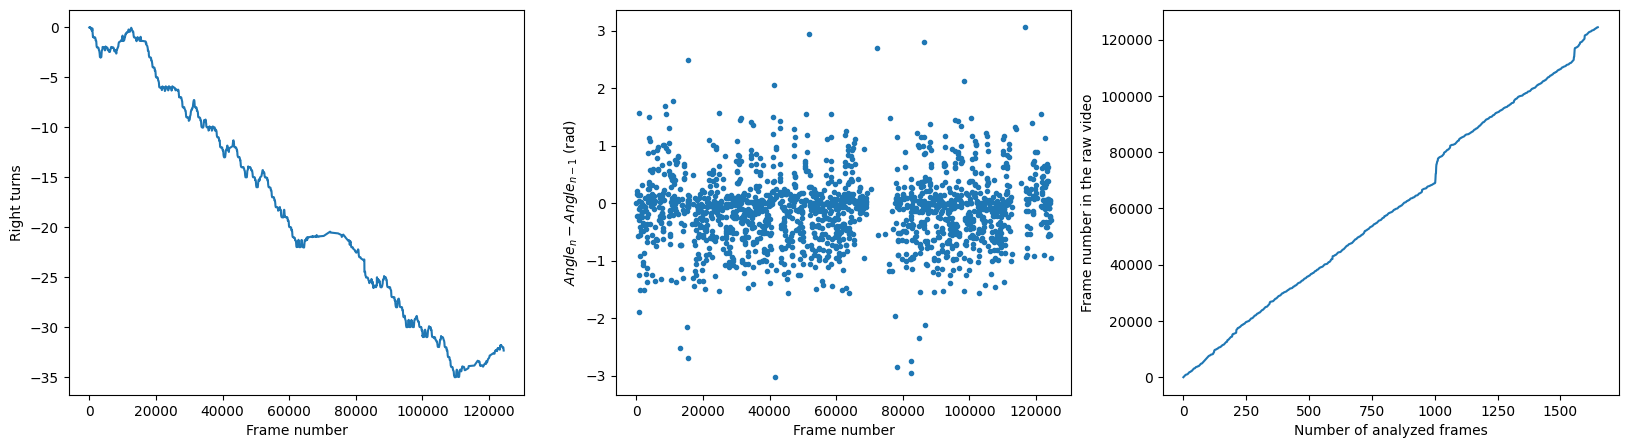

The animal made -32.3472509607818 right turns in segment 2
Analyzing F:\Ephys\Haitham\Videos\20240513_video ...
Temp folder: F:\Ephys\Haitham\Videos\20240513_video\Temp
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240513_video\Temp\Image_Segment1
Starting to extract posture
Overall # of frames:  1800  found with (before cropping) frame dimensions:  880 704


 99%|█████████▉| 1782/1800 [01:00<00:00, 29.22it/s]


Saving results in F:\Ephys\Haitham\Videos\20240513_video\Temp\Image_Segment1...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240513_video\Temp\New1_Segment1/
Starting to extract posture
Overall # of frames:  967  found with (before cropping) frame dimensions:  880 704


 99%|█████████▉| 960/967 [00:32<00:00, 29.20it/s]


Saving results in F:\Ephys\Haitham\Videos\20240513_video\Temp\New1_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240513_video\Temp\New2_Segment1/
Starting to extract posture
Overall # of frames:  406  found with (before cropping) frame dimensions:  880 704


 99%|█████████▊| 400/406 [00:14<00:00, 28.49it/s]


Saving results in F:\Ephys\Haitham\Videos\20240513_video\Temp\New2_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240513_video\Temp\New3_Segment1/
Starting to extract posture
Overall # of frames:  261  found with (before cropping) frame dimensions:  880 704


100%|█████████▉| 260/261 [00:09<00:00, 28.36it/s]


Saving results in F:\Ephys\Haitham\Videos\20240513_video\Temp\New3_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240513_video\Temp\New4_Segment1/
Starting to extract posture
Overall # of frames:  187  found with (before cropping) frame dimensions:  880 704


 96%|█████████▋| 180/187 [00:06<00:00, 26.95it/s]


Saving results in F:\Ephys\Haitham\Videos\20240513_video\Temp\New4_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240513_video\Temp\New5_Segment1/
Starting to extract posture
Overall # of frames:  125  found with (before cropping) frame dimensions:  880 704


 96%|█████████▌| 120/125 [00:04<00:00, 25.47it/s]


Saving results in F:\Ephys\Haitham\Videos\20240513_video\Temp\New5_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240513_video\Temp\New6_Segment1/
Starting to extract posture
Overall # of frames:  57  found with (before cropping) frame dimensions:  880 704


 88%|████████▊ | 50/57 [00:02<00:00, 19.77it/s]


Saving results in F:\Ephys\Haitham\Videos\20240513_video\Temp\New6_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240513_video\Temp\New7_Segment1/
Starting to extract posture
Overall # of frames:  37  found with (before cropping) frame dimensions:  880 704


 81%|████████  | 30/37 [00:01<00:00, 16.68it/s]


Saving results in F:\Ephys\Haitham\Videos\20240513_video\Temp\New7_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240513_video\Temp\New8_Segment1/
Starting to extract posture
Overall # of frames:  11  found with (before cropping) frame dimensions:  880 704


 91%|█████████ | 10/11 [00:00<00:00, 10.70it/s]


Saving results in F:\Ephys\Haitham\Videos\20240513_video\Temp\New8_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
2757 out of 3851 frames are good.
2757 out of 2757 frames are good after filtering.


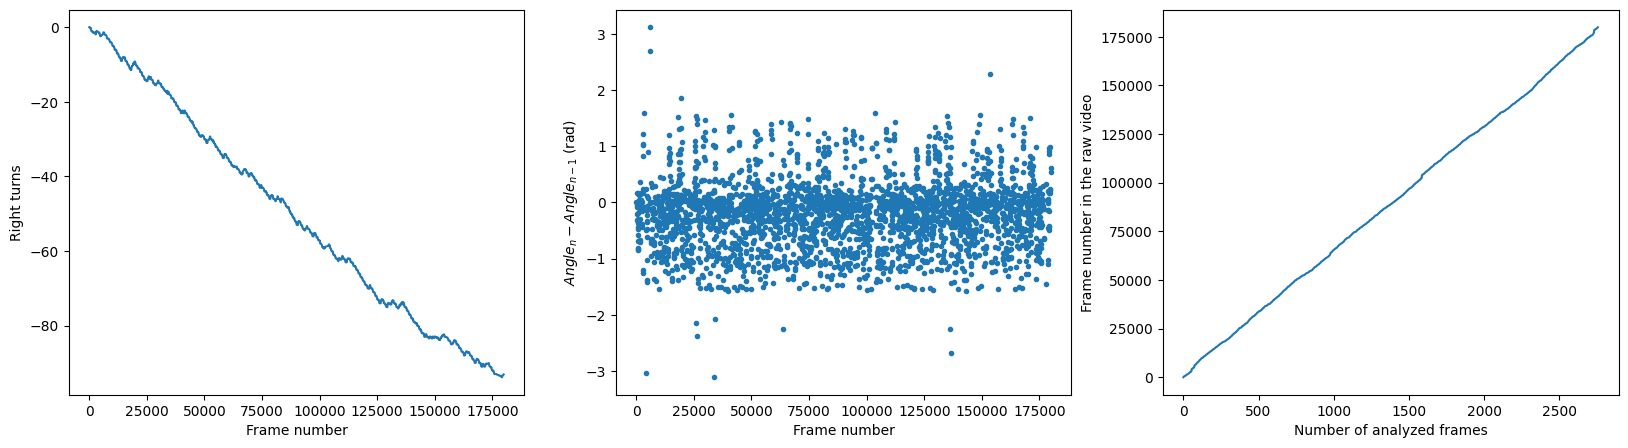

The animal made -93.11367960041734 right turns in segment 1
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240513_video\Temp\Image_Segment2
Starting to extract posture
Overall # of frames:  1368  found with (before cropping) frame dimensions:  880 704


100%|█████████▉| 1365/1368 [00:46<00:00, 29.34it/s]


Saving results in F:\Ephys\Haitham\Videos\20240513_video\Temp\Image_Segment2...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240513_video\Temp\New1_Segment2/
Starting to extract posture
Overall # of frames:  635  found with (before cropping) frame dimensions:  880 704


 99%|█████████▉| 630/635 [00:21<00:00, 28.87it/s]


Saving results in F:\Ephys\Haitham\Videos\20240513_video\Temp\New1_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240513_video\Temp\New2_Segment2/
Starting to extract posture
Overall # of frames:  416  found with (before cropping) frame dimensions:  880 704


 99%|█████████▊| 410/416 [00:14<00:00, 28.57it/s]


Saving results in F:\Ephys\Haitham\Videos\20240513_video\Temp\New2_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240513_video\Temp\New3_Segment2/
Starting to extract posture
Overall # of frames:  332  found with (before cropping) frame dimensions:  880 704


 99%|█████████▉| 330/332 [00:11<00:00, 28.60it/s]


Saving results in F:\Ephys\Haitham\Videos\20240513_video\Temp\New3_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240513_video\Temp\New4_Segment2/
Starting to extract posture
Overall # of frames:  261  found with (before cropping) frame dimensions:  880 704


100%|█████████▉| 260/261 [00:09<00:00, 28.46it/s]


Saving results in F:\Ephys\Haitham\Videos\20240513_video\Temp\New4_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240513_video\Temp\New5_Segment2/
Starting to extract posture
Overall # of frames:  204  found with (before cropping) frame dimensions:  880 704


 98%|█████████▊| 200/204 [00:07<00:00, 26.60it/s]


Saving results in F:\Ephys\Haitham\Videos\20240513_video\Temp\New5_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240513_video\Temp\New6_Segment2/
Starting to extract posture
Overall # of frames:  139  found with (before cropping) frame dimensions:  880 704


 94%|█████████▎| 130/139 [00:05<00:00, 25.17it/s]


Saving results in F:\Ephys\Haitham\Videos\20240513_video\Temp\New6_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240513_video\Temp\New7_Segment2/
Starting to extract posture
Overall # of frames:  101  found with (before cropping) frame dimensions:  880 704


 99%|█████████▉| 100/101 [00:03<00:00, 25.62it/s]


Saving results in F:\Ephys\Haitham\Videos\20240513_video\Temp\New7_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240513_video\Temp\New8_Segment2/
Starting to extract posture
Overall # of frames:  62  found with (before cropping) frame dimensions:  880 704


 97%|█████████▋| 60/62 [00:02<00:00, 23.20it/s]


Saving results in F:\Ephys\Haitham\Videos\20240513_video\Temp\New8_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240513_video\Temp\New9_Segment2/
Starting to extract posture
Overall # of frames:  26  found with (before cropping) frame dimensions:  880 704


 77%|███████▋  | 20/26 [00:01<00:00, 14.56it/s]


Saving results in F:\Ephys\Haitham\Videos\20240513_video\Temp\New9_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240513_video\Temp\New10_Segment2/
Starting to extract posture
Overall # of frames:  13  found with (before cropping) frame dimensions:  880 704


 77%|███████▋  | 10/13 [00:00<00:00, 10.88it/s]


Saving results in F:\Ephys\Haitham\Videos\20240513_video\Temp\New10_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240513_video\Temp\New11_Segment2/
Starting to extract posture
Overall # of frames:  1  found with (before cropping) frame dimensions:  880 704


  0%|          | 0/1 [00:00<?, ?it/s]


Saving results in F:\Ephys\Haitham\Videos\20240513_video\Temp\New11_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
1712 out of 3558 frames are good.
1712 out of 1712 frames are good after filtering.


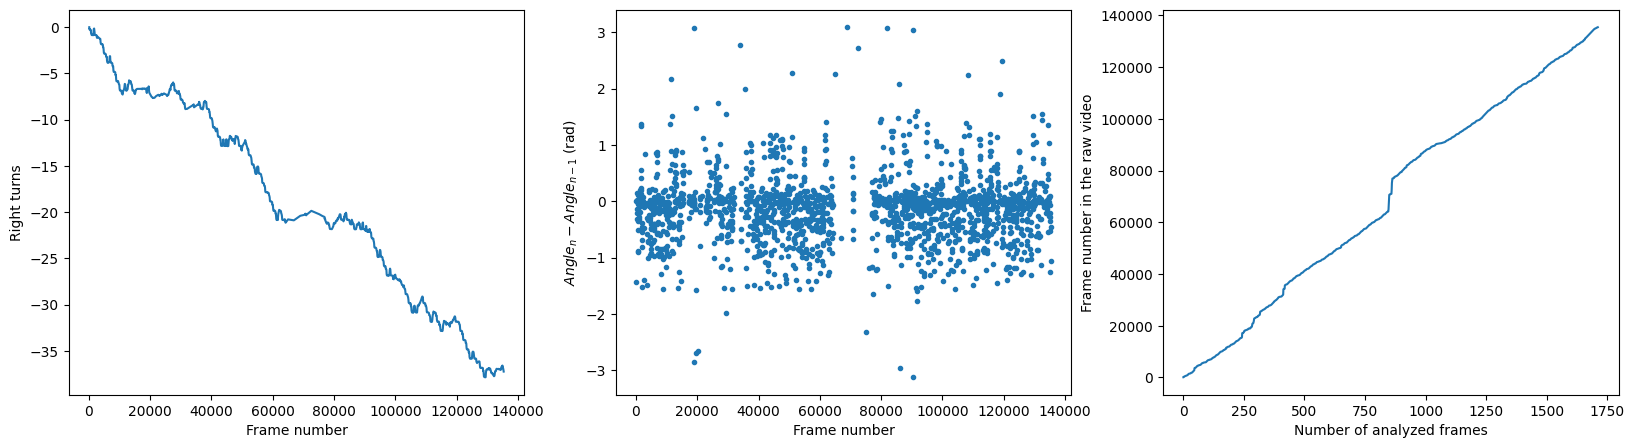

The animal made -37.23442911974304 right turns in segment 2
Analyzing F:\Ephys\Haitham\Videos\20240516_video ...
Temp folder: F:\Ephys\Haitham\Videos\20240516_video\Temp
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240516_video\Temp\Image_Segment1
Frames already analyzed! F:\Ephys\Haitham\Videos\20240516_video\Temp\Image_Segment1\Image_Segment1DLC_resnet50_Haitham_topviewMay2shuffle1_1030000.h5
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240516_video\Temp\New1_Segment1/
Frames already analyzed! F:\Ephys\Haitham\Videos\20240516_video\Temp\New1_Segment1/New1_Segment1DLC_resnet50_Haitham_topviewMay2shuffle1_1030000.h5
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240516_video\Temp\New2_Segment1/
Frames already analyzed! F:\Ephys\Haitham\Videos\20240516_video\Temp\New2_Segment1/New2_Segment1DLC_resnet50_Haitham_topviewMay2shuffle1_1030000.h5
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240516_video\Temp\New3_Segment1/
Frames already analyzed! F:\Ephys\Haitham\Videos\20240516_video\Temp\New3_Segment1/New3_Segment1DLC_resnet50_Haitham_topviewMay2shuffle1_1030000.h5
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240516_video\Temp\New4_Segment1/
Frames already analyzed! F:\Ephys\Haitham\Videos\20240516_video\Temp\New4_Segment1/New4_Segment1DLC_resnet50_Haitham_topviewMay2shuffle1_1030000.h5
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240516_video\Temp\New5_Segment1/
Frames already analyzed! F:\Ephys\Haitham\Videos\20240516_video\Temp\New5_Segment1/New5_Segment1DLC_resnet50_Haitham_topviewMay2shuffle1_1030000.h5
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240516_video\Temp\New6_Segment1/
Frames already analyzed! F:\Ephys\Haitham\Videos\20240516_video\Temp\New6_Segment1/New6_Segment1DLC_resnet50_Haitham_topviewMay2shuffle1_1030000.h5
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240516_video\Temp\New7_Segment1/
Frames already analyzed! F:\Ephys\Haitham\Videos\20240516_video\Temp\New7_Segment1/New7_Segment1DLC_resnet50_Haitham_topviewMay2shuffle1_1030000.h5
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240516_video\Temp\New8_Segment1/
Frames already analyzed! F:\Ephys\Haitham\Videos\20240516_video\Temp\New8_Segment1/New8_Segment1DLC_resnet50_Haitham_topviewMay2shuffle1_1030000.h5
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240516_video\Temp\New9_Segment1/
Frames already analyzed! F:\Ephys\Haitham\Videos\20240516_video\Temp\New9_Segment1/New9_Segment1DLC_resnet50_Haitham_topviewMay2shuffle1_1030000.h5
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240516_video\Temp\New10_Segment1/
Frames already analyzed! F:\Ephys\Haitham\Videos\20240516_video\Temp\New10_Segment1/New10_Segment1DLC_resnet50_Haitham_topviewMay2shuffle1_1030000.h5
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240516_video\Temp\New11_Segment1/
Frames already analyzed! F:\Ephys\Haitham\Videos\20240516_video\Temp\New11_Segment1/New11_Segment1DLC_resnet50_Haitham_topviewMay2shuffle1_1030000.h5
2479 out of 3897 frames are good.
2475 out of 2479 frames are good after filtering.


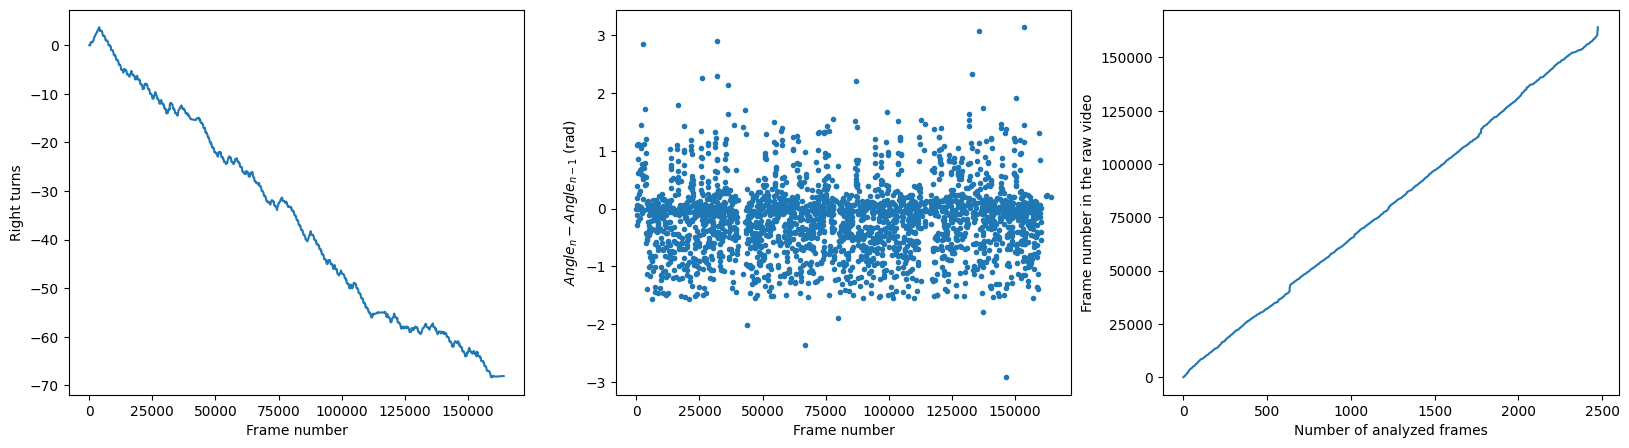

The animal made -68.09684350248932 right turns in segment 1
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240516_video\Temp\Image_Segment2
Frames already analyzed! F:\Ephys\Haitham\Videos\20240516_video\Temp\Image_Segment2\Image_Segment2DLC_resnet50_Haitham_topviewMay2shuffle1_1030000.h5
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240516_video\Temp\New1_Segment2/
Frames already analyzed! F:\Ephys\Haitham\Videos\20240516_video\Temp\New1_Segment2/New1_Segment2DLC_resnet50_Haitham_topviewMay2shuffle1_1030000.h5
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240516_video\Temp\New2_Segment2/
Frames already analyzed! F:\Ephys\Haitham\Videos\20240516_video\Temp\New2_Segment2/New2_Segment2DLC_resnet50_Haitham_topviewMay2shuffle1_1030000.h5
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240516_video\Temp\New3_Segment2/
Frames already analyzed! F:\Ephys\Haitham\Videos\20240516_video\Temp\New3_Segment2/New3_Segment2DLC_resnet50_Haitham_topviewMay2shuffle1_1030000.h5
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240516_video\Temp\New4_Segment2/
Frames already analyzed! F:\Ephys\Haitham\Videos\20240516_video\Temp\New4_Segment2/New4_Segment2DLC_resnet50_Haitham_topviewMay2shuffle1_1030000.h5
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240516_video\Temp\New5_Segment2/
Frames already analyzed! F:\Ephys\Haitham\Videos\20240516_video\Temp\New5_Segment2/New5_Segment2DLC_resnet50_Haitham_topviewMay2shuffle1_1030000.h5
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240516_video\Temp\New6_Segment2/
Frames already analyzed! F:\Ephys\Haitham\Videos\20240516_video\Temp\New6_Segment2/New6_Segment2DLC_resnet50_Haitham_topviewMay2shuffle1_1030000.h5
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240516_video\Temp\New7_Segment2/
Frames already analyzed! F:\Ephys\Haitham\Videos\20240516_video\Temp\New7_Segment2/New7_Segment2DLC_resnet50_Haitham_topviewMay2shuffle1_1030000.h5
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240516_video\Temp\New8_Segment2/
Frames already analyzed! F:\Ephys\Haitham\Videos\20240516_video\Temp\New8_Segment2/New8_Segment2DLC_resnet50_Haitham_topviewMay2shuffle1_1030000.h5
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240516_video\Temp\New9_Segment2/
Frames already analyzed! F:\Ephys\Haitham\Videos\20240516_video\Temp\New9_Segment2/New9_Segment2DLC_resnet50_Haitham_topviewMay2shuffle1_1030000.h5
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240516_video\Temp\New10_Segment2/
Frames already analyzed! F:\Ephys\Haitham\Videos\20240516_video\Temp\New10_Segment2/New10_Segment2DLC_resnet50_Haitham_topviewMay2shuffle1_1030000.h5
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240516_video\Temp\New11_Segment2/
Frames already analyzed! F:\Ephys\Haitham\Videos\20240516_video\Temp\New11_Segment2/New11_Segment2DLC_resnet50_Haitham_topviewMay2shuffle1_1030000.h5
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240516_video\Temp\New12_Segment2/
Frames already analyzed! F:\Ephys\Haitham\Videos\20240516_video\Temp\New12_Segment2/New12_Segment2DLC_resnet50_Haitham_topviewMay2shuffle1_1030000.h5
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240516_video\Temp\New13_Segment2/
Frames already analyzed! F:\Ephys\Haitham\Videos\20240516_video\Temp\New13_Segment2/New13_Segment2DLC_resnet50_Haitham_topviewMay2shuffle1_1030000.h5
2187 out of 4702 frames are good.
2183 out of 2187 frames are good after filtering.


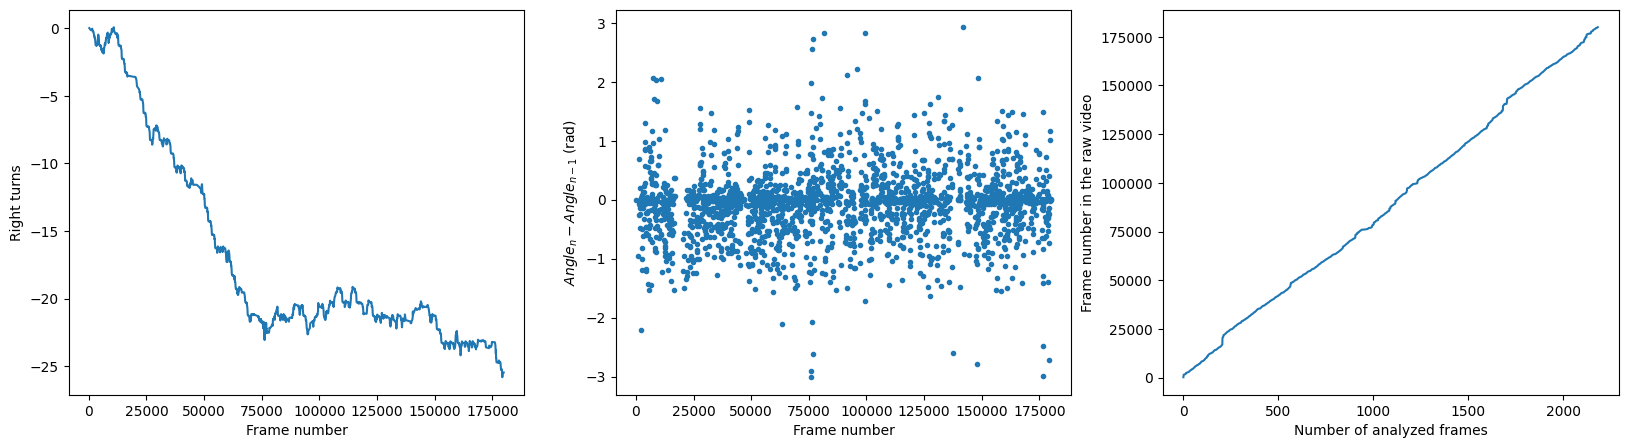

The animal made -25.45864455207201 right turns in segment 2
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240516_video\Temp\Image_Segment3
Frames already analyzed! F:\Ephys\Haitham\Videos\20240516_video\Temp\Image_Segment3\Image_Segment3DLC_resnet50_Haitham_topviewMay2shuffle1_1030000.h5
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240516_video\Temp\New1_Segment3/
Frames already analyzed! F:\Ephys\Haitham\Videos\20240516_video\Temp\New1_Segment3/New1_Segment3DLC_resnet50_Haitham_topviewMay2shuffle1_1030000.h5
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240516_video\Temp\New2_Segment3/
Frames already analyzed! F:\Ephys\Haitham\Videos\20240516_video\Temp\New2_Segment3/New2_Segment3DLC_resnet50_Haitham_topviewMay2shuffle1_1030000.h5
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240516_video\Temp\New3_Segment3/
Frames already analyzed! F:\Ephys\Haitham\Videos\20240516_video\Temp\New3_Segment3/New3_Segment3DLC_resnet50_Haitham_topviewMay2shuffle1_1030000.h5
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240516_video\Temp\New4_Segment3/
Frames already analyzed! F:\Ephys\Haitham\Videos\20240516_video\Temp\New4_Segment3/New4_Segment3DLC_resnet50_Haitham_topviewMay2shuffle1_1030000.h5
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240516_video\Temp\New5_Segment3/
Frames already analyzed! F:\Ephys\Haitham\Videos\20240516_video\Temp\New5_Segment3/New5_Segment3DLC_resnet50_Haitham_topviewMay2shuffle1_1030000.h5
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240516_video\Temp\New6_Segment3/
Frames already analyzed! F:\Ephys\Haitham\Videos\20240516_video\Temp\New6_Segment3/New6_Segment3DLC_resnet50_Haitham_topviewMay2shuffle1_1030000.h5
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240516_video\Temp\New7_Segment3/
Frames already analyzed! F:\Ephys\Haitham\Videos\20240516_video\Temp\New7_Segment3/New7_Segment3DLC_resnet50_Haitham_topviewMay2shuffle1_1030000.h5
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240516_video\Temp\New8_Segment3/
Frames already analyzed! F:\Ephys\Haitham\Videos\20240516_video\Temp\New8_Segment3/New8_Segment3DLC_resnet50_Haitham_topviewMay2shuffle1_1030000.h5
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240516_video\Temp\New9_Segment3/
Frames already analyzed! F:\Ephys\Haitham\Videos\20240516_video\Temp\New9_Segment3/New9_Segment3DLC_resnet50_Haitham_topviewMay2shuffle1_1030000.h5
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240516_video\Temp\New10_Segment3/
Frames already analyzed! F:\Ephys\Haitham\Videos\20240516_video\Temp\New10_Segment3/New10_Segment3DLC_resnet50_Haitham_topviewMay2shuffle1_1030000.h5
2367 out of 4065 frames are good.
2366 out of 2367 frames are good after filtering.


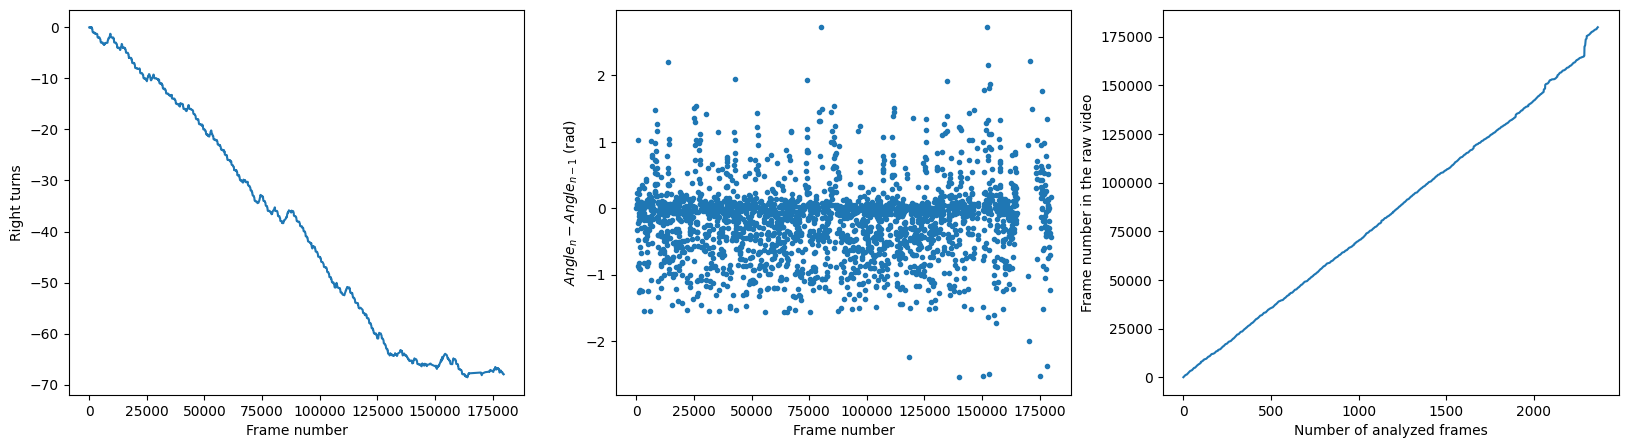

The animal made -67.97688366907984 right turns in segment 3
Analyzing F:\Ephys\Haitham\Videos\20240517_video ...
Temp folder: F:\Ephys\Haitham\Videos\20240517_video\Temp
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240517_video\Temp\Image_Segment1
Starting to extract posture
Overall # of frames:  1827  found with (before cropping) frame dimensions:  880 704


100%|█████████▉| 1818/1827 [01:01<00:00, 29.68it/s]


Saving results in F:\Ephys\Haitham\Videos\20240517_video\Temp\Image_Segment1...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240517_video\Temp\New1_Segment1/
Starting to extract posture
Overall # of frames:  886  found with (before cropping) frame dimensions:  880 704


 99%|█████████▉| 880/886 [00:30<00:00, 29.09it/s]


Saving results in F:\Ephys\Haitham\Videos\20240517_video\Temp\New1_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240517_video\Temp\New2_Segment1/
Starting to extract posture
Overall # of frames:  533  found with (before cropping) frame dimensions:  880 704


 99%|█████████▉| 530/533 [00:18<00:00, 29.14it/s]


Saving results in F:\Ephys\Haitham\Videos\20240517_video\Temp\New2_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240517_video\Temp\New3_Segment1/
Starting to extract posture
Overall # of frames:  437  found with (before cropping) frame dimensions:  880 704


 98%|█████████▊| 430/437 [00:15<00:00, 28.53it/s]


Saving results in F:\Ephys\Haitham\Videos\20240517_video\Temp\New3_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240517_video\Temp\New4_Segment1/
Starting to extract posture
Overall # of frames:  331  found with (before cropping) frame dimensions:  880 704


100%|█████████▉| 330/331 [00:11<00:00, 28.38it/s]


Saving results in F:\Ephys\Haitham\Videos\20240517_video\Temp\New4_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240517_video\Temp\New5_Segment1/
Starting to extract posture
Overall # of frames:  237  found with (before cropping) frame dimensions:  880 704


 97%|█████████▋| 230/237 [00:08<00:00, 27.52it/s]


Saving results in F:\Ephys\Haitham\Videos\20240517_video\Temp\New5_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240517_video\Temp\New6_Segment1/
Starting to extract posture
Overall # of frames:  132  found with (before cropping) frame dimensions:  880 704


 98%|█████████▊| 130/132 [00:04<00:00, 26.99it/s]


Saving results in F:\Ephys\Haitham\Videos\20240517_video\Temp\New6_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240517_video\Temp\New7_Segment1/
Starting to extract posture
Overall # of frames:  87  found with (before cropping) frame dimensions:  880 704


 92%|█████████▏| 80/87 [00:03<00:00, 24.69it/s]


Saving results in F:\Ephys\Haitham\Videos\20240517_video\Temp\New7_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240517_video\Temp\New8_Segment1/
Starting to extract posture
Overall # of frames:  46  found with (before cropping) frame dimensions:  880 704


 87%|████████▋ | 40/46 [00:02<00:00, 19.87it/s]


Saving results in F:\Ephys\Haitham\Videos\20240517_video\Temp\New8_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240517_video\Temp\New9_Segment1/
Starting to extract posture
Overall # of frames:  17  found with (before cropping) frame dimensions:  880 704


 59%|█████▉    | 10/17 [00:01<00:00,  8.55it/s]


Saving results in F:\Ephys\Haitham\Videos\20240517_video\Temp\New9_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240517_video\Temp\New10_Segment1/
Starting to extract posture
Overall # of frames:  10  found with (before cropping) frame dimensions:  880 704


  0%|          | 0/10 [00:00<?, ?it/s]


Saving results in F:\Ephys\Haitham\Videos\20240517_video\Temp\New10_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240517_video\Temp\New11_Segment1/
Starting to extract posture
Overall # of frames:  8  found with (before cropping) frame dimensions:  880 704


  0%|          | 0/8 [00:00<?, ?it/s]


Saving results in F:\Ephys\Haitham\Videos\20240517_video\Temp\New11_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
2788 out of 4551 frames are good.
2787 out of 2788 frames are good after filtering.


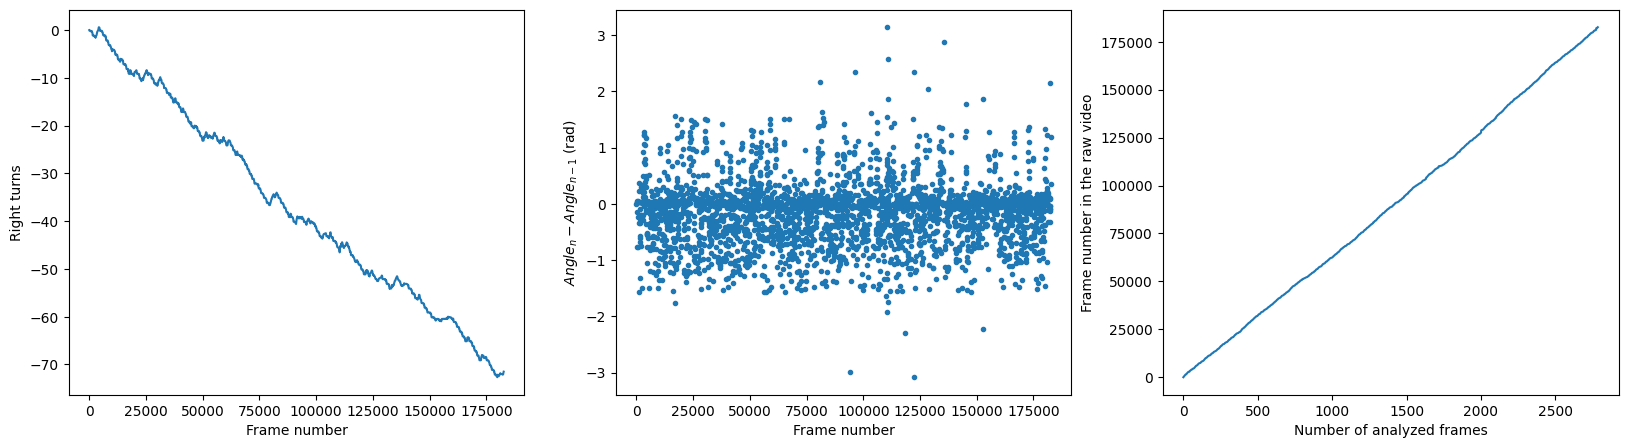

The animal made -71.49983548745469 right turns in segment 1
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240517_video\Temp\Image_Segment2
Starting to extract posture
Overall # of frames:  1227  found with (before cropping) frame dimensions:  880 704


100%|█████████▉| 1224/1227 [00:40<00:00, 29.94it/s]


Saving results in F:\Ephys\Haitham\Videos\20240517_video\Temp\Image_Segment2...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240517_video\Temp\New1_Segment2/
Starting to extract posture
Overall # of frames:  597  found with (before cropping) frame dimensions:  880 704


 99%|█████████▉| 590/597 [00:20<00:00, 29.34it/s]


Saving results in F:\Ephys\Haitham\Videos\20240517_video\Temp\New1_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240517_video\Temp\New2_Segment2/
Starting to extract posture
Overall # of frames:  328  found with (before cropping) frame dimensions:  880 704


 98%|█████████▊| 320/328 [00:11<00:00, 28.11it/s]


Saving results in F:\Ephys\Haitham\Videos\20240517_video\Temp\New2_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240517_video\Temp\New3_Segment2/
Starting to extract posture
Overall # of frames:  251  found with (before cropping) frame dimensions:  880 704


100%|█████████▉| 250/251 [00:08<00:00, 27.96it/s]


Saving results in F:\Ephys\Haitham\Videos\20240517_video\Temp\New3_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240517_video\Temp\New4_Segment2/
Starting to extract posture
Overall # of frames:  240  found with (before cropping) frame dimensions:  880 704


 96%|█████████▌| 230/240 [00:08<00:00, 26.76it/s]


Saving results in F:\Ephys\Haitham\Videos\20240517_video\Temp\New4_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240517_video\Temp\New5_Segment2/
Starting to extract posture
Overall # of frames:  187  found with (before cropping) frame dimensions:  880 704


 96%|█████████▋| 180/187 [00:06<00:00, 26.62it/s]


Saving results in F:\Ephys\Haitham\Videos\20240517_video\Temp\New5_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240517_video\Temp\New6_Segment2/
Starting to extract posture
Overall # of frames:  101  found with (before cropping) frame dimensions:  880 704


 99%|█████████▉| 100/101 [00:03<00:00, 26.68it/s]


Saving results in F:\Ephys\Haitham\Videos\20240517_video\Temp\New6_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240517_video\Temp\New7_Segment2/
Starting to extract posture
Overall # of frames:  47  found with (before cropping) frame dimensions:  880 704


 85%|████████▌ | 40/47 [00:02<00:00, 19.85it/s]


Saving results in F:\Ephys\Haitham\Videos\20240517_video\Temp\New7_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240517_video\Temp\New8_Segment2/
Starting to extract posture
Overall # of frames:  41  found with (before cropping) frame dimensions:  880 704


 98%|█████████▊| 40/41 [00:01<00:00, 21.61it/s]


Saving results in F:\Ephys\Haitham\Videos\20240517_video\Temp\New8_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240517_video\Temp\New9_Segment2/
Starting to extract posture
Overall # of frames:  18  found with (before cropping) frame dimensions:  880 704


 56%|█████▌    | 10/18 [00:01<00:00,  8.59it/s]


Saving results in F:\Ephys\Haitham\Videos\20240517_video\Temp\New9_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Haitham_topview-HY-2024-05-02\dlc-models\iteration-0\Haitham_topviewMay2-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Ephys\Haitham\Videos\20240517_video\Temp\New10_Segment2/
Starting to extract posture
Overall # of frames:  10  found with (before cropping) frame dimensions:  880 704


  0%|          | 0/10 [00:00<?, ?it/s]


Saving results in F:\Ephys\Haitham\Videos\20240517_video\Temp\New10_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
1623 out of 3047 frames are good.
1620 out of 1623 frames are good after filtering.


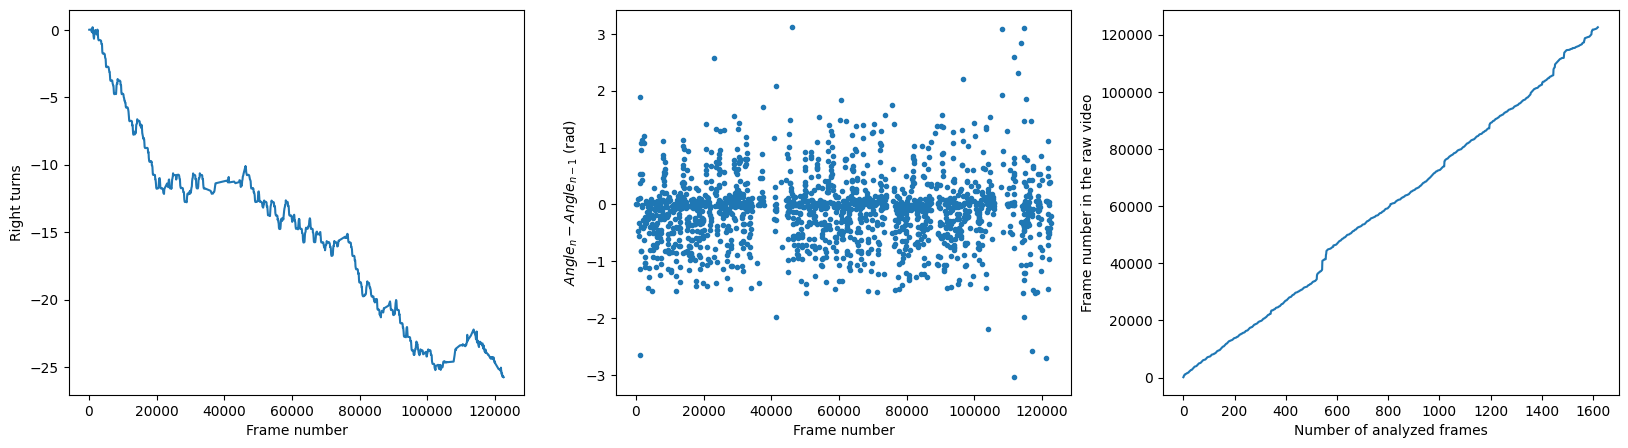

The animal made -25.746010855731175 right turns in segment 2


In [3]:
dir_to_analysis = r'F:\Ephys\Haitham\Videos'
sessions = ['20240418',
            '20240422',
            '20240425',
            '20240427',
            '20240506',
            '20240511',
            '20240513',
            '20240516',
            '20240517']
dlc_model = r'D:\DLC\Haitham_topview-HY-2024-05-02\config.yaml'
frame_interval = 100

p_thres = 0.9
v_angle_thres = 0.5*np.pi

for session in sessions:
    dir_video = os.path.join(dir_to_analysis, session + '_video')
    dir_temp = os.path.join(dir_video, 'Temp')
    dir_image = os.path.join(dir_temp, 'Image')
    print('Analyzing', dir_video, '...')
    print('Temp folder:', dir_temp)

    ts = h5py.File(os.path.join(dir_video, 'timestamps.mat'))
    n_files = ts['ts']['topviews'].size
    n_char = ts[ts['ts']['topviews'][0][0]].size
    video_path_all = []
    for k in range(n_files):
        filename = ''
        for j in range(n_char):
            filename += chr(ts[ts['ts']['topviews'][k][0]][j][0])

        video_path_all.append(filename)

    # Start analysis
    for k in range(len(video_path_all)):
        segment_num = k+1
        video_path = video_path_all[k]
        df_out = analyze_segment(segment_num, os.path.join(dir_video, video_path), dir_temp, dir_video)

        turning_angle = df_out['turning_angle'].to_numpy()
        d_angle = df_out['d_angle']

        plt.figure(figsize=(20,5))

        plt.subplot(1,3,1)
        plt.plot(df_out['frame_number'].to_numpy(), turning_angle/np.pi/2)
        plt.ylabel('Right turns')
        plt.xlabel('Frame number')

        plt.subplot(1,3,2)
        plt.plot(df_out['frame_number'].to_numpy(), d_angle, '.')
        plt.ylabel('$Angle_n - Angle_{n-1}$ (rad)', )
        plt.xlabel('Frame number')

        plt.subplot(1,3,3)
        plt.plot(df_out['frame_number'].to_numpy())
        plt.ylabel('Frame number in the raw video')
        plt.xlabel('Number of analyzed frames')

        plt.show()

        print('The animal made', turning_angle[-1]/np.pi/2, 'right turns in segment', segment_num)
